## Libraries

In [1]:
import abc
import codecs
import inspect
import json
import logging
import gc
import os
import pickle
import random
import sys
import time
import warnings

import catboost as cat
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

from abc import abstractmethod
from collections import Counter
from contextlib import contextmanager
from pathlib import Path
from typing import List, Optional, Union, Tuple, Dict, Sequence

from catboost import CatBoostClassifier, CatBoostRegressor
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.multiclass import unique_labels
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm_notebook

## Config

In [2]:
cat_conf_string = '''
dataset:
  dir: "../input/data-science-bowl-2019/"
  feature_dir: "../features"
  params:

features:
  - PastSummary

av:
  split_params:
    random_state: 42
    n_splits: 5

  model_params:
    objective: "binary"
    metric: "auc"
    boosting: "gbdt"
    max_depth: 7
    num_leaves: 75
    learning_rate: 0.01
    colsample_bytree: 0.7
    subsample: 0.1
    subsample_freq: 1
    seed: 111
    feature_fraction_seed: 111
    drop_seed: 111
    verbose: -1
    n_jobs: -1
    first_metric_only: True

  train_params:
    num_boost_round: 50000
    early_stopping_rounds: 100
    verbose_eval: 100

model:
  name: "classwise_cat_data_enhansed"
  mode: "regression"
  sampling:
    name: "none"
    params:
      k_neighbors: 7
      n_jobs: 4
      random_state: 42
      acc_0_coef: 1.0
      acc_1_coef: 1.0
      acc_2_coef: 1.0
      acc_3_coef: 1.0

  model_params:
    loss_function: "RMSE"
    task_type: "CPU"
    iterations: 6000
    early_stopping_rounds: 100
    random_seed: 42

  train_params:
    mode: "regression"
    
post_process:
  params:
    reverse: False
    n_overall: 20
    n_classwise: 20

val:
  name: "group_kfold"
  params:
    n_splits: 5
    random_state: 111

output_dir: "output"
'''


lgb_conf_string = '''
dataset:
  dir: "../input/data-science-bowl-2019/"
  feature_dir: "../features"
  params:

features:
  - PastSummary

av:
  split_params:
    random_state: 42
    n_splits: 5

  model_params:
    objective: "binary"
    metric: "auc"
    boosting: "gbdt"
    max_depth: 7
    num_leaves: 75
    learning_rate: 0.01
    colsample_bytree: 0.7
    subsample: 0.1
    subsample_freq: 1
    seed: 111
    feature_fraction_seed: 111
    drop_seed: 111
    verbose: -1
    first_metric_only: True

  train_params:
    num_boost_round: 50000
    early_stopping_rounds: 100
    verbose_eval: 100

model:
  name: "classwise_lgbm_data_enhansed"
  mode: "regression"
  sampling:
    name: "none"
    params:
      k_neighbors: 7
      n_jobs: 4
      random_state: 42
      acc_0_coef: 1.0
      acc_1_coef: 1.0
      acc_2_coef: 1.0
      acc_3_coef: 1.0

  model_params:
    objective: "regression"
    metric: "qwk"
    boosting_type: "gbdt"
    max_depth: -1
    num_leaves: 256
    tree_learner: "serial"
    learning_rate: 0.01
    subsample: 0.7
    subsample_freq: 1
    colsample_bytree: 0.5
    max_bin: 255
    seed: 71
    bagging_seed: 71
    feature_fraction_seed: 71
    drop_seed: 71
    verbose: -1
    n_jobs: -1
    first_metric_only: False

  train_params:
    num_boost_round: 10000
    early_stopping_rounds: 100
    verbose_eval: 100
    
post_process:
  params:
    reverse: False
    n_overall: 20
    n_classwise: 20

val:
  name: "group_kfold"
  params:
    n_splits: 5
    random_state: 222

output_dir: "output"
'''

In [3]:
cat_conf_string2 = '''
dataset:
  dir: "../input/data-science-bowl-2019/"
  feature_dir: "../features"
  params:

features:
  - PastSummary

av:
  split_params:
    random_state: 42
    n_splits: 5

  model_params:
    objective: "binary"
    metric: "auc"
    boosting: "gbdt"
    max_depth: 7
    num_leaves: 75
    learning_rate: 0.01
    colsample_bytree: 0.7
    subsample: 0.1
    subsample_freq: 1
    seed: 111
    feature_fraction_seed: 111
    drop_seed: 111
    verbose: -1
    n_jobs: -1
    first_metric_only: True

  train_params:
    num_boost_round: 50000
    early_stopping_rounds: 100
    verbose_eval: 100

model:
  name: "catboost_data_enhansed"
  mode: "regression"
  sampling:
    name: "none"
    params:
      k_neighbors: 7
      n_jobs: 4
      random_state: 42
      acc_0_coef: 1.0
      acc_1_coef: 1.0
      acc_2_coef: 1.0
      acc_3_coef: 1.0

  model_params:
    loss_function: "RMSE"
    task_type: "CPU"
    iterations: 6000
    early_stopping_rounds: 100
    random_seed: 42

  train_params:
    mode: "regression"
    
post_process:
  params:
    reverse: False
    n_overall: 20
    n_classwise: 20

val:
  name: "group_kfold"
  params:
    n_splits: 5
    random_state: 111

output_dir: "output"
'''


lgb_conf_string2 = '''
dataset:
  dir: "../input/data-science-bowl-2019/"
  feature_dir: "../features"
  params:

features:
  - PastSummary

av:
  split_params:
    random_state: 42
    n_splits: 5

  model_params:
    objective: "binary"
    metric: "auc"
    boosting: "gbdt"
    max_depth: 7
    num_leaves: 75
    learning_rate: 0.01
    colsample_bytree: 0.7
    subsample: 0.1
    subsample_freq: 1
    seed: 111
    feature_fraction_seed: 111
    drop_seed: 111
    verbose: -1
    first_metric_only: True

  train_params:
    num_boost_round: 50000
    early_stopping_rounds: 100
    verbose_eval: 100

model:
  name: "lgbm_data_enhansed"
  mode: "regression"
  sampling:
    name: "none"
    params:
      k_neighbors: 7
      n_jobs: 4
      random_state: 42
      acc_0_coef: 1.0
      acc_1_coef: 1.0
      acc_2_coef: 1.0
      acc_3_coef: 1.0

  model_params:
    objective: "regression"
    metric: "qwk"
    boosting_type: "gbdt"
    max_depth: -1
    num_leaves: 256
    tree_learner: "serial"
    learning_rate: 0.01
    subsample: 0.7
    subsample_freq: 1
    colsample_bytree: 0.5
    max_bin: 255
    seed: 71
    bagging_seed: 71
    feature_fraction_seed: 71
    drop_seed: 71
    verbose: -1
    n_jobs: -1
    first_metric_only: False

  train_params:
    num_boost_round: 10000
    early_stopping_rounds: 100
    verbose_eval: 100
    
post_process:
  params:
    reverse: False
    n_overall: 20
    n_classwise: 20

val:
  name: "group_kfold"
  params:
    n_splits: 5
    random_state: 222

output_dir: "output"
'''

In [4]:
cat_config = dict(yaml.load(cat_conf_string, Loader=yaml.SafeLoader))
lgb_config = dict(yaml.load(lgb_conf_string, Loader=yaml.SafeLoader))
cat_config2 = dict(yaml.load(cat_conf_string2, Loader=yaml.SafeLoader))
lgb_config2 = dict(yaml.load(lgb_conf_string2, Loader=yaml.SafeLoader))

In [5]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    
    
seed_everything(42)

## Functions and Classes

### utils

#### checker

In [6]:
def feature_existence_checker(feature_path: Path,
                              feature_names: List[str]) -> bool:
    features = [f.name for f in feature_path.glob("*.ftr")]
    for f in feature_names:
        if f + "_train.ftr" not in features:
            return False
        if f + "_valid.ftr" not in features:
            return False
        if f + "_test.ftr" not in features:
            return False
    return True

#### jsonutil

In [7]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def save_json(config: dict, save_path: Union[str, Path]):
    f = codecs.open(str(save_path), mode="w", encoding="utf-8")
    json.dump(config, f, indent=4, cls=MyEncoder, ensure_ascii=False)
    f.close()

#### logger

In [8]:
def configure_logger(config_name: str, log_dir: Union[Path, str], debug: bool):
    if isinstance(log_dir, str):
        Path(log_dir).mkdir(parents=True, exist_ok=True)
    else:
        log_dir.mkdir(parents=True, exist_ok=True)

    log_filename = config_name.split("/")[-1].replace(".yml", ".log")
    log_filepath = log_dir / log_filename \
        if isinstance(log_dir, Path) else Path(log_dir) / log_filename

    # delete the old log
    if log_filepath.exists():
        with open(log_filepath, mode="w"):
            pass

    level = logging.DEBUG if debug else logging.INFO
    logging.basicConfig(
        filename=str(log_filepath),
        level=level,
        format="%(asctime)s %(levelname)s %(message)s",
        datefmt="%m/%d/%Y %I:%M:%S %p")

#### timer

In [9]:
@contextmanager
def timer(name: str, log: bool = False):
    t0 = time.time()
    msg = f"[{name}] start"
    if not log:
        print(msg)
    else:
        logging.info(msg)
    yield

    msg = f"[{name}] done in {time.time() - t0:.2f} s"
    if not log:
        print(msg)
    else:
        logging.info(msg)

#### visualization

In [10]:
def plot_confusion_matrix(y_true,
                          y_pred,
                          classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          save_path: Path = Path("./")):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, fontsize=25)
    plt.yticks(tick_marks, fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)
    plt.ylabel('True label', fontsize=25)
    plt.title(title, fontsize=30)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size="5%", pad=0.15)
    cbar = ax.figure.colorbar(im, ax=ax, cax=cax)
    cbar.ax.tick_params(labelsize=20)

    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        #            title=title,
        ylabel='True label',
        xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                fontsize=20,
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig(save_path)

### validation

In [11]:
def group_kfold(df: pd.DataFrame, groups: pd.Series,
                config: dict) -> List[Tuple[np.ndarray, np.ndarray]]:
    params = config["val"]["params"]
    kf = KFold(
        n_splits=params["n_splits"],
        random_state=params["random_state"],
        shuffle=True)
    uniq_groups = groups.unique()
    split = []
    for trn_grp_idx, val_grp_idx in kf.split(uniq_groups):
        trn_grp = uniq_groups[trn_grp_idx]
        val_grp = uniq_groups[val_grp_idx]
        trn_idx = df[df["group"].isin(trn_grp)].index.values
        val_idx = df[df["group"].isin(val_grp)].index.values
        split.append((trn_idx, val_idx))

    return split


def get_validation(df: pd.DataFrame,
                   config: dict) -> List[Tuple[np.ndarray, np.ndarray]]:
    name: str = config["val"]["name"]

    func = globals().get(name)
    if func is None:
        raise NotImplementedError

    if "group" in name:
        groups = df["group"]
        return func(df, groups, config)
    else:
        return func(df, config)

#### feature_selection

In [12]:
def select_features(cols: List[str], feature_importance: pd.DataFrame,
                    config: dict) -> List[str]:
    if config["val"].get("n_delete") is None:
        return cols

    n_delete = config["val"].get("n_delete")
    importance_sorted_cols = feature_importance.sort_values(
        by="value", ascending=False)["feature"].tolist()
    if isinstance(n_delete, int):
        remove_cols = importance_sorted_cols[:n_delete]
        for col in remove_cols:
            cols.remove(col)
    elif isinstance(n_delete, float):
        n_delete_int = int(n_delete * len(importance_sorted_cols))
        remove_cols = importance_sorted_cols[:n_delete_int]
        for col in remove_cols:
            cols.remove(col)
    return cols

### sampling

#### factory

In [13]:
def smote(x_trn: np.ndarray, y_trn: np.ndarray,
          config: dict) -> Tuple[np.ndarray, np.ndarray]:
    params = config["model"]["sampling"]["params"]
    sm = SMOTE(
        k_neighbors=params["k_neighbors"], random_state=params["random_state"])
    sampled_x, sampled_y = sm.fit_resample(x_trn, y_trn)
    return sampled_x, sampled_y


def random_under_sample(x_trn: np.ndarray, y_trn: np.ndarray,
                        config: dict) -> Tuple[np.ndarray, np.ndarray]:
    params = config["model"]["sampling"]["params"]
    acc_0 = (y_trn == 0).sum().astype(int)
    acc_1 = (y_trn == 1).sum().astype(int)
    acc_2 = (y_trn == 2).sum().astype(int)
    acc_3 = (y_trn == 3).sum().astype(int)
    rus = RandomUnderSampler({
        0: int(params["acc_0_coef"] * acc_0),
        1: int(params["acc_1_coef"] * acc_1),
        2: int(params["acc_2_coef"] * acc_2),
        3: int(params["acc_3_coef"] * acc_3)
    },
                             random_state=params["random_state"])
    sampled_x, sampled_y = rus.fit_resample(x_trn, y_trn)
    return sampled_x, sampled_y


def random_under_sample_and_smote(
        x_trn: np.ndarray, y_trn: np.ndarray,
        config: dict) -> Tuple[np.ndarray, np.ndarray]:
    sampled_x, sampled_y = random_under_sample(x_trn, y_trn, config)
    sampled_x, sampled_y = smote(sampled_x, sampled_y, config)
    return sampled_x, sampled_y


def get_sampling(x_trn: np.ndarray, y_trn: np.ndarray,
                 config: dict) -> Tuple[np.ndarray, np.ndarray]:
    if config["model"]["sampling"]["name"] == "none":
        return x_trn, y_trn

    policy = config["model"]["sampling"]["name"]
    func = globals().get(policy)
    if func is None:
        raise NotImplementedError
    return func(x_trn, y_trn, config)

### evaluation

#### metrics

In [14]:
def qwk(y_true: Union[np.ndarray, list],
        y_pred: Union[np.ndarray, list],
        max_rat: int = 3) -> float:
    y_true_ = np.asarray(y_true)
    y_pred_ = np.asarray(y_pred)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    uniq_class = np.unique(y_true_)
    for i in uniq_class:
        hist1[int(i)] = len(np.argwhere(y_true_ == i))
        hist2[int(i)] = len(np.argwhere(y_pred_ == i))

    numerator = np.square(y_true_ - y_pred_).sum()

    denominator = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            denominator += hist1[i] * hist2[j] * (i - j) * (i - j)

    denominator /= y_true_.shape[0]
    return 1 - numerator / denominator


def calc_metric(y_true: Union[np.ndarray, list],
                y_pred: Union[np.ndarray, list]) -> float:
    return qwk(y_true, y_pred)

#### optimization

In [15]:
class OptimizedRounder(object):
    def __init__(self,
                 n_overall: int = 5,
                 n_classwise: int = 5,
                 reverse: bool = False):
        self.n_overall = n_overall
        self.n_classwise = n_classwise
        self.coef = [0.25, 0.5, 0.75]
        self.reverse = reverse

    def _loss(self, X: np.ndarray, y: np.ndarray) -> float:
        X_p = np.digitize(X, self.coef)
        ll = -calc_metric(y, X_p)
        return ll

    def fit(self, X: np.ndarray, y: np.ndarray):
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(0.01, 0.4), (0.4, 0.7), (0.7, 0.9)]
        for _ in range(self.n_overall):
            if self.reverse:
                search = reversed(range(3))
            else:
                search = iter(range(3))
            for idx in search:
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                self.coef[idx] = a
                la = self._loss(X, y)
                self.coef[idx] = b
                lb = self._loss(X, y)
                for it in range(self.n_classwise):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        self.coef[idx] = a
                        la = self._loss(X, y)
                    else:
                        b = b - (b - a) * golden2
                        self.coef[idx] = b
                        lb = self._loss(X, y)

    def predict(self, X: np.ndarray) -> np.ndarray:
        X_p = np.digitize(X, self.coef)
        return X_p

#### cat

In [16]:
class CatBoostOptimizedQWKMetric(object):
    def __init__(self,
                 n_overall: int = 5,
                 n_classwise: int = 5,
                 reverse: bool = False):
        self.n_overall = n_overall
        self.n_classwise = n_classwise
        self.reverse = reverse

    def get_final_error(self, error: float, weight: float) -> float:
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target,
                 weight: Optional[Sequence[float]]) -> Tuple[float, float]:
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]
        approx_np = np.array(approx)
        target_np = (np.array(target) * 3).astype(int)

        OptR = OptimizedRounder(
            n_classwise=self.n_classwise,
            n_overall=self.n_overall,
            reverse=self.reverse)
        OptR.fit(approx_np, target_np)

        y_pred = OptR.predict(approx_np).astype(int)
        y_true = target_np.astype(int)

        weight_sum = 1.0
        qwk = calc_metric(y_true, y_pred)
        return qwk, weight_sum

#### lgbm

In [17]:
def lgb_classification_qwk(y_pred: np.ndarray,
                           data: lgb.Dataset) -> Tuple[str, float, bool]:
    y_true = data.get_label()
    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return "qwk", calc_metric(y_true, y_pred), True


def lgb_regression_qwk(y_pred: np.ndarray,
                       data: lgb.Dataset) -> Tuple[str, float, bool]:
    y_true = (data.get_label() * 3).astype(int)
    y_pred = y_pred.reshape(-1)

    OptR = OptimizedRounder(n_classwise=3, n_overall=3)
    OptR.fit(y_pred, y_true)

    y_pred = OptR.predict(y_pred).astype(int)
    qwk = calc_metric(y_true, y_pred)

    return "qwk", qwk, True


def lgb_residual_qwk_closure(mean_target: np.ndarray):
    def lgb_residual_qwk(y_pred: np.ndarray,
                         data: lgb.Dataset) -> Tuple[str, float, bool]:
        y_true = (data.get_label() * 3).astype(int)
        y_pred = y_pred.reshape(-1)

        y_true = (y_true + mean_target).astype(int)
        y_pred = y_pred + mean_target

        OptR = OptimizedRounder(n_classwise=5, n_overall=5)
        OptR.fit(y_pred, y_true)

        y_pred = OptR.predict(y_pred).astype(int)
        qwk = calc_metric(y_true, y_pred)

        return "qwk", qwk, True

    return lgb_residual_qwk

### models

#### base

In [18]:
# type alias
AoD = Union[np.ndarray, pd.DataFrame]
AoS = Union[np.ndarray, pd.Series]
CatModel = Union[cat.CatBoostClassifier, cat.CatBoostRegressor]
LGBModel = Union[lgb.LGBMClassifier, lgb.LGBMRegressor]
Model = Union[CatModel, LGBModel]


class BaseModel(object):
    @abstractmethod
    def fit(self, x_train: AoD, y_train: AoS, x_valid: AoD, y_valid: AoS,
            x_valid2: Optional[AoD], y_valid2: Optional[AoS],
            config: dict) -> Tuple[Model, dict]:
        raise NotImplementedError

    @abstractmethod
    def get_best_iteration(self, model: Model) -> int:
        raise NotImplementedError

    @abstractmethod
    def predict(self, model: Model, features: AoD) -> np.ndarray:
        raise NotImplementedError

    @abstractmethod
    def get_feature_importance(self, model: Model) -> np.ndarray:
        raise NotImplementedError

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     valid_preds: Optional[np.ndarray], y: np.ndarray,
                     y_valid: Optional[np.ndarray], config: dict
                     ) -> Tuple[np.ndarray, np.ndarray, Optional[np.ndarray]]:
        return oof_preds, test_preds, valid_preds

    def cv(self,
           y_train: AoS,
           train_features: AoD,
           test_features: AoD,
           y_valid: Optional[AoS],
           valid_features: Optional[AoD],
           feature_name: List[str],
           folds_ids: List[Tuple[np.ndarray, np.ndarray]],
           config: dict,
           log: bool = True
           ) -> Tuple[List[Model], np.ndarray, np.
                      ndarray, Optional[np.ndarray], pd.DataFrame, dict]:
        # initialize
        test_preds = np.zeros(len(test_features))
        oof_preds = np.zeros(len(train_features))
        if valid_features is not None:
            valid_preds = np.zeros(len(valid_features))
        else:
            valid_preds = None
        importances = pd.DataFrame(index=feature_name)
        best_iteration = 0.0
        cv_score_list: List[dict] = []
        models: List[Model] = []

        if config["model"]["mode"] == "residual":
            self.mean_targets: Dict[str, List[np.ndarray]] = {
                "train": [],
                "valid": [],
                "valid2": [valid_features["mean_target"].values],
                "test": [test_features["mean_target"].values]
            }
            valid_features.drop("mean_target", axis=1, inplace=True)
            test_features.drop("mean_target", axis=1, inplace=True)
            for t_idx, v_idx in folds_ids:
                self.mean_targets["train"].append(
                    train_features.loc[t_idx, "mean_target"].values)
                self.mean_targets["valid"].append(
                    train_features.loc[v_idx, "mean_target"].values)
            train_features.drop("mean_target", axis=1, inplace=True)
            feature_name.remove("mean_target")

        X = train_features.values if isinstance(train_features, pd.DataFrame) \
            else train_features
        y = y_train.values if isinstance(y_train, pd.Series) \
            else y_train

        X_valid = valid_features.values if isinstance(
            valid_features, pd.DataFrame) else valid_features
        y_valid = y_valid.values if isinstance(y_valid, pd.Series) \
            else y_valid

        for i_fold, (trn_idx, val_idx) in enumerate(folds_ids):
            self.fold = i_fold
            # get train data and valid data
            x_trn = X[trn_idx]
            y_trn = y[trn_idx]
            x_val = X[val_idx]
            y_val = y[val_idx]

            x_trn, y_trn = get_sampling(x_trn, y_trn, config)

            # train model
            model, best_score = self.fit(
                x_trn, y_trn, x_val, y_val, X_valid, y_valid, config=config)
            cv_score_list.append(best_score)
            models.append(model)
            best_iteration += self.get_best_iteration(model) / len(folds_ids)

            # predict oof and test
            oof_preds[val_idx] = self.predict(model, x_val).reshape(-1)
            test_preds += self.predict(
                model, test_features).reshape(-1) / len(folds_ids)

            if valid_features is not None:
                valid_preds += self.predict(
                    model, valid_features).reshape(-1) / len(folds_ids)

            if config["model"]["mode"] == "residual":
                oof_preds[val_idx] += self.mean_targets["valid"][self.fold]
                test_preds += self.mean_targets["test"][0]
                valid_preds += self.mean_targets["valid2"][0]

            # get feature importances
            importances_tmp = pd.DataFrame(
                self.get_feature_importance(model),
                columns=[f"gain_{i_fold+1}"],
                index=feature_name)
            importances = importances.join(importances_tmp, how="inner")

        # summary of feature importance
        feature_importance = importances.mean(axis=1)

        # save raw prediction
        self.raw_oof_preds = oof_preds
        self.raw_test_preds = test_preds
        self.raw_valid_preds = valid_preds

        # post_process (if you have any)
        oof_preds, test_preds, valid_preds = self.post_process(
            oof_preds, test_preds, valid_preds, y_train, y_valid, config)

        # print oof score
        oof_score = calc_metric(y_train, oof_preds)
        print(f"oof score: {oof_score:.5f}")
        if valid_features is not None:
            valid_score = calc_metric(y_valid, valid_preds)
            print(f"valid score: {valid_score:.5f}")

        if log:
            logging.info(f"oof score: {oof_score:.5f}")
            if valid_features is not None:
                logging.info(f"valid score: {valid_score:.5f}")

        evals_results = {
            "evals_result": {
                "oof_score":
                oof_score,
                "cv_score": {
                    f"cv{i + 1}": cv_score
                    for i, cv_score in enumerate(cv_score_list)
                },
                "n_data":
                len(train_features),
                "best_iteration":
                best_iteration,
                "n_features":
                len(train_features.columns),
                "feature_importance":
                feature_importance.sort_values(ascending=False).to_dict()
            }
        }

        if valid_features is not None:
            evals_results["valid_score"] = valid_score
        return (models, oof_preds, test_preds, valid_preds, feature_importance,
                evals_results)

#### classwise

In [19]:
# type alias
AoD = Union[np.ndarray, pd.DataFrame]
AoS = Union[np.ndarray, pd.Series]
CatModel = Union[cat.CatBoostClassifier, cat.CatBoostRegressor]
LGBModel = Union[lgb.LGBMClassifier, lgb.LGBMRegressor]
Model = Union[CatModel, LGBModel]


class ClassWiseBase(object):
    @abstractmethod
    def fit(self, x_train: AoD, y_train: AoS,
            valid_sets: List[Tuple[AoD, AoS]],
            config: dict) -> Tuple[Model, dict]:
        raise NotImplementedError

    @abstractmethod
    def get_best_iteration(self, model: Model) -> int:
        raise NotImplementedError

    @abstractmethod
    def predict(self, model: Model, features: AoD) -> np.ndarray:
        raise NotImplementedError

    @abstractmethod
    def get_feature_importance(self, model: Model) -> np.ndarray:
        raise NotImplementedError

    def post_process(self, preds_set: List[Tuple[np.ndarray, np.ndarray]],
                     test_preds: np.ndarray,
                     config: dict) -> Tuple[List[np.ndarray], np.ndarray]:
        return [p[0] for p in preds_set], test_preds

    def cv(self,
           y_train: AoS,
           train_features: AoD,
           test_features: AoD,
           y_valid: AoS,
           valid_features: AoD,
           feature_name: List[str],
           folds_ids: List[Tuple[np.ndarray, np.ndarray]],
           config: dict,
           log: bool = True) -> Tuple[Dict[int, List[Model]], np.ndarray, np.
                                      ndarray, np.ndarray, dict, dict]:
        # initialize
        test_preds = np.zeros(len(test_features))
        oof_preds = np.zeros(len(train_features))
        valid_preds = np.zeros(len(valid_features))

        all_classes = train_features["session_title"].unique()

        classwise_mean_importances = {}
        classwise_best_iteration = {c: 0.0 for c in all_classes}
        classwise_cv_score_list = {c: [] for c in all_classes}
        classwise_models = {c: [] for c in all_classes}

        X = train_features.values if isinstance(train_features, pd.DataFrame) \
            else train_features
        y = y_train.values if isinstance(y_train, pd.Series) else y_train

        X_valid = valid_features.values if isinstance(valid_features, pd.DataFrame) \
            else valid_features
        y_valid = y_valid.values if isinstance(y_valid, pd.Series) else y_valid

        for c in all_classes:
            importances = pd.DataFrame(index=feature_name)
            train_c_idx = train_features.query(
                f"session_title == {c}").index.values
            valid_c_idx = valid_features.query(
                f"session_title == {c}").index.values
            test_c_idx = test_features.query(
                f"session_title == {c}").index.values

            X_c_valid = X_valid[valid_c_idx]
            y_c_valid = y_valid[valid_c_idx]

            print(f"Assessment Class: {c}")

            for i_fold, (trn_idx, val_idx) in enumerate(folds_ids):
                print("=" * 15)
                print(f"Fold: {i_fold + 1}")
                print("=" * 15)

                trn_c_idx = np.intersect1d(trn_idx, train_c_idx)
                val_c_idx = np.intersect1d(val_idx, train_c_idx)

                # get train data and valid data
                X_trn = X[trn_c_idx]
                y_trn = y[trn_c_idx]
                X_val = X[val_c_idx]
                y_val = y[val_c_idx]

                # train model
                model, best_score = self.fit(
                    X_trn,
                    y_trn,
                    valid_sets=[(X_val, y_val), (X_c_valid, y_c_valid)],
                    config=config)
                classwise_cv_score_list[c].append(best_score)
                classwise_models[c].append(model)
                classwise_best_iteration[c] += self.get_best_iteration(model)

                # predict oof and test, valid
                oof_preds[val_c_idx] = self.predict(model, X_val).reshape(-1)
                test_preds[test_c_idx] += self.predict(
                    model, test_features.loc[test_c_idx, :]).reshape(-1) / len(
                        folds_ids)
                valid_preds[valid_c_idx] += self.predict(
                    model, X_c_valid).reshape(-1) / len(folds_ids)

                # get feature importances
                importances_tmp = pd.DataFrame(
                    self.get_feature_importance(model),
                    columns=[f"class_{c}_gain_{i_fold+1}"],
                    index=feature_name)
                importances = importances.join(importances_tmp, how="inner")

            # summary of feature importance
            classwise_mean_importances[c] = importances.mean(axis=1)

        # save raw prediction
        self.raw_oof_preds = oof_preds
        self.raw_test_preds = test_preds
        self.raw_valid_preds = valid_preds

        # post_process
        [oof_preds, valid_preds], test_preds = self.post_process(
            [(oof_preds, y_train), (valid_preds, y_valid)], test_preds, config)

        # print oof score
        oof_score = calc_metric(y_train, oof_preds)
        print(f"oof score: {oof_score:.5f}")
        valid_score = calc_metric(y_valid, valid_preds)
        print(f"valid score: {valid_score:.5f}")

        if log:
            logging.info(f"oof score: {oof_score:.5f}")
            logging.info(f"valid score: {valid_score:.5f}")

        eval_results = {
            "eval_result": {
                "oof_score": oof_score,
                "valid_score": valid_score,
                "cv_results": {},
                "n_data": len(train_features),
                "n_features": len(train_features.columns),
                "best_iterations": {
                    f"Assessment {c}": v
                    for c, v in classwise_best_iteration.items()
                },
                "feature_importances": {}
            }
        }

        for c, v in classwise_cv_score_list.items():
            eval_results["eval_result"]["cv_results"][f"Assessment {c}"] = \
                {f"cv{i + 1}": cv_score for i, cv_score in enumerate(v)}

        for c, fi in classwise_mean_importances.items():
            eval_results["eval_result"]["feature_importances"][
                f"Assessment {c}"] = fi.sort_values(ascending=False).to_dict()

        return (classwise_models, oof_preds, test_preds, valid_preds,
                classwise_mean_importances, eval_results)

#### base_data_enhansed

In [52]:
# type alias
AoD = Union[np.ndarray, pd.DataFrame]
AoS = Union[np.ndarray, pd.Series]
CatModel = Union[cat.CatBoostClassifier, cat.CatBoostRegressor]
LGBModel = Union[lgb.LGBMClassifier, lgb.LGBMRegressor]
Model = Union[CatModel, LGBModel]


class BaseDataEnhansed(object):
    @abstractmethod
    def fit(self, x_train: AoD, y_train: AoS, x_valid: AoD, y_valid: AoS,
            config: dict) -> Tuple[Model, dict]:
        raise NotImplementedError

    @abstractmethod
    def get_best_iteration(self, model: Model) -> int:
        raise NotImplementedError

    @abstractmethod
    def predict(self, model: Model, features: AoD) -> np.ndarray:
        raise NotImplementedError

    @abstractmethod
    def get_feature_importance(self, model: Model) -> np.ndarray:
        raise NotImplementedError

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     valid_preds: Optional[np.ndarray], y: np.ndarray,
                     y_valid: Optional[np.ndarray], config: dict
                     ) -> Tuple[np.ndarray, np.ndarray, Optional[np.ndarray]]:
        return oof_preds, test_preds, valid_preds

    def cv(self,
           y_train: AoS,
           train_features: pd.DataFrame,
           test_features: pd.DataFrame,
           y_valid: AoS,
           valid_features: pd.DataFrame,
           feature_name: List[str],
           groups: AoS,
           config: dict,
           log: bool = True
           ) -> Tuple[List[Model], np.ndarray, np.
                      ndarray, Optional[np.ndarray], pd.DataFrame, dict]:
        # initialize
        test_preds = np.zeros(len(test_features))
        train_valid_preds = np.zeros(len(train_features) + len(valid_features))
        n_original = len(train_features)

        importances = pd.DataFrame(index=feature_name)
        best_iteration = 0.0
        cv_score_list: List[dict] = []
        models: List[Model] = []
            
        X_df = pd.concat([train_features, valid_features],
                      axis=0,
                      sort=False).reset_index(drop=True)
        y = np.concatenate([y_train, y_valid])
        
        X_df["group"] = groups
        splits = get_validation(X_df, config)
        X_df.drop("group", axis=1, inplace=True)
        
        X = X_df.values

        for i_fold, (trn_idx, val_idx) in enumerate(splits):
            self.fold = i_fold
            # get train data and valid data
            x_trn = X[trn_idx]
            y_trn = y[trn_idx]
            x_val = X[val_idx]
            y_val = y[val_idx]

            # train model
            model, best_score = self.fit(
                x_trn, y_trn, x_val, y_val, config=config)
            cv_score_list.append(best_score)
            models.append(model)
            best_iteration += self.get_best_iteration(model) / len(splits)

            # predict oof and test
            train_valid_preds[val_idx] = self.predict(model, x_val).reshape(-1)
            test_preds += self.predict(
                model, test_features).reshape(-1) / len(splits)

            # get feature importances
            importances_tmp = pd.DataFrame(
                self.get_feature_importance(model),
                columns=[f"gain_{i_fold+1}"],
                index=feature_name)
            importances = importances.join(importances_tmp, how="inner")

        # summary of feature importance
        feature_importance = importances.mean(axis=1)
        
        oof_preds = train_valid_preds[:n_original]
        valid_preds = train_valid_preds[n_original:]

        # save raw prediction
        self.raw_oof_preds = oof_preds
        self.raw_test_preds = test_preds
        self.raw_valid_preds = valid_preds

        # post_process (if you have any)
        oof_preds, test_preds, valid_preds = self.post_process(
            oof_preds, test_preds, valid_preds, y_train, y_valid, config)

        # print oof score
        oof_score = calc_metric(y_train, oof_preds)
        print(f"oof score: {oof_score:.5f}")
        valid_score = calc_metric(y_valid, valid_preds)
        print(f"valid score: {valid_score:.5f}")

        if log:
            logging.info(f"oof score: {oof_score:.5f}")
            logging.info(f"valid score: {valid_score:.5f}")

        evals_results = {
            "evals_result": {
                "oof_score":
                oof_score,
                "valid_score":
                valid_score,
                "cv_score": {
                    f"cv{i + 1}": cv_score
                    for i, cv_score in enumerate(cv_score_list)
                },
                "n_data":
                len(train_features),
                "best_iteration":
                best_iteration,
                "n_features":
                len(train_features.columns),
                "feature_importance":
                feature_importance.sort_values(ascending=False).to_dict()
            }
        }
        return (models, oof_preds, test_preds, valid_preds, feature_importance,
                evals_results)

#### classwise_data_enhansed

In [53]:
# type alias
AoD = Union[np.ndarray, pd.DataFrame]
AoS = Union[np.ndarray, pd.Series]
CatModel = Union[cat.CatBoostClassifier, cat.CatBoostRegressor]
LGBModel = Union[lgb.LGBMClassifier, lgb.LGBMRegressor]
Model = Union[CatModel, LGBModel]


class ClassWiseBaseDataEnhansed(object):
    @abstractmethod
    def fit(self, x_train: AoD, y_train: AoS,
            x_valid: AoD, y_valid: AoS,
            config: dict) -> Tuple[Model, dict]:
        raise NotImplementedError

    @abstractmethod
    def get_best_iteration(self, model: Model) -> int:
        raise NotImplementedError

    @abstractmethod
    def predict(self, model: Model, features: AoD) -> np.ndarray:
        raise NotImplementedError

    @abstractmethod
    def get_feature_importance(self, model: Model) -> np.ndarray:
        raise NotImplementedError

    def post_process(self, preds_set: List[Tuple[np.ndarray, np.ndarray]],
                     test_preds: np.ndarray,
                     config: dict) -> Tuple[List[np.ndarray], np.ndarray]:
        return [p[0] for p in preds_set], test_preds

    def cv(self,
           y_train: AoS,
           train_features: AoD,
           test_features: AoD,
           y_valid: AoS,
           valid_features: AoD,
           feature_name: List[str],
           groups: AoS,
           config: dict,
           log: bool = True) -> Tuple[Dict[int, List[Model]], np.ndarray, np.
                                      ndarray, np.ndarray, dict, dict]:
        # initialize
        test_preds = np.zeros(len(test_features))
        train_valid_preds = np.zeros(len(train_features) + len(valid_features))
        n_train = len(train_features)

        all_classes = train_features["session_title"].unique()

        classwise_mean_importances = {}
        classwise_best_iteration = {c: 0.0 for c in all_classes}
        classwise_cv_score_list = {c: [] for c in all_classes}
        classwise_models = {c: [] for c in all_classes}
        
        X_df = pd.concat([train_features, valid_features],
                      axis=0,
                      sort=False).reset_index(drop=True)
        y = np.concatenate([y_train, y_valid])
        
        X_df["group"] = groups
        splits = get_validation(X_df, config)
        X_df.drop("group", axis=1, inplace=True)
        
        X = X_df.values

        for c in all_classes:
            importances = pd.DataFrame(index=feature_name)
            train_c_idx = X_df.query(
                f"session_title == {c}").index.values
            test_c_idx = test_features.query(
                f"session_title == {c}").index.values

            print(f"Assessment Class: {c}")

            for i_fold, (trn_idx, val_idx) in enumerate(splits):
                print("=" * 15)
                print(f"Fold: {i_fold + 1}")
                print("=" * 15)

                trn_c_idx = np.intersect1d(trn_idx, train_c_idx)
                val_c_idx = np.intersect1d(val_idx, train_c_idx)

                # get train data and valid data
                X_trn = X[trn_c_idx]
                y_trn = y[trn_c_idx]
                X_val = X[val_c_idx]
                y_val = y[val_c_idx]

                # train model
                model, best_score = self.fit(
                    X_trn,
                    y_trn,
                    X_val,
                    y_val,
                    config=config)
                classwise_cv_score_list[c].append(best_score)
                classwise_models[c].append(model)
                classwise_best_iteration[c] += self.get_best_iteration(model)

                # predict oof and test, valid
                train_valid_preds[val_c_idx] = self.predict(model, X_val).reshape(-1)
                test_preds[test_c_idx] += self.predict(
                    model, test_features.loc[test_c_idx, :]).reshape(-1) / len(
                        splits)

                # get feature importances
                importances_tmp = pd.DataFrame(
                    self.get_feature_importance(model),
                    columns=[f"class_{c}_gain_{i_fold+1}"],
                    index=feature_name)
                importances = importances.join(importances_tmp, how="inner")

            # summary of feature importance
            classwise_mean_importances[c] = importances.mean(axis=1)

        oof_preds = train_valid_preds[:n_train]
        valid_preds = train_valid_preds[n_train:]

        # save raw prediction
        self.raw_oof_preds = oof_preds
        self.raw_test_preds = test_preds
        self.raw_valid_preds = valid_preds

        # post_process
        [oof_preds, valid_preds], test_preds = self.post_process(
            [(oof_preds, y_train), (valid_preds, y_valid)], test_preds, config)

        # print oof score
        oof_score = calc_metric(y_train, oof_preds)
        print(f"oof score: {oof_score:.5f}")
        valid_score = calc_metric(y_valid, valid_preds)
        print(f"valid score: {valid_score:.5f}")

        if log:
            logging.info(f"oof score: {oof_score:.5f}")
            logging.info(f"valid score: {valid_score:.5f}")

        eval_results = {
            "eval_result": {
                "oof_score": oof_score,
                "valid_score": valid_score,
                "cv_results": {},
                "n_data": len(train_features),
                "n_features": len(train_features.columns),
                "best_iterations": {
                    f"Assessment {c}": v
                    for c, v in classwise_best_iteration.items()
                },
                "feature_importances": {}
            }
        }

        for c, v in classwise_cv_score_list.items():
            eval_results["eval_result"]["cv_results"][f"Assessment {c}"] = \
                {f"cv{i + 1}": cv_score for i, cv_score in enumerate(v)}

        for c, fi in classwise_mean_importances.items():
            eval_results["eval_result"]["feature_importances"][
                f"Assessment {c}"] = fi.sort_values(ascending=False).to_dict()

        return (classwise_models, oof_preds, test_preds, valid_preds,
                classwise_mean_importances, eval_results)

#### cat

In [54]:
CatModel = Union[CatBoostClassifier, CatBoostRegressor]


class CatBoostModel(BaseModel):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            x_valid: np.ndarray, y_valid: np.ndarray,
            x_valid2: Optional[np.ndarray], y_valid2: Optional[np.ndarray],
            config: dict) -> Tuple[CatModel, dict]:
        model_params = config["model"]["model_params"]
        mode = config["model"]["mode"]
        self.mode = mode
        if mode == "regression":
            model = CatBoostRegressor(
                eval_metric=CatBoostOptimizedQWKMetric(
                    reverse=config["post_process"]["params"]["reverse"],
                    n_overall=3,
                    n_classwise=3),
                **model_params)
            self.denominator = y_train.max()
            y_train = y_train / y_train.max()
            y_valid = y_valid / self.denominator
            if y_valid2 is not None:
                y_valid2 = y_valid2 / self.denominator
        else:
            model = CatBoostClassifier(**model_params)

        if x_valid2 is not None:
            eval_sets = [(x_valid2, y_valid2)]
        else:
            eval_sets = [(x_valid, y_valid)]

        model.fit(
            x_train,
            y_train,
            eval_set=eval_sets,
            use_best_model=True,
            verbose=model_params["early_stopping_rounds"])
        best_score = model.best_score_
        return model, best_score

    def get_best_iteration(self, model: CatModel):
        return model.best_iteration_

    def predict(self, model: CatModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        return model.predict(features)

    def get_feature_importance(self, model: CatModel) -> np.ndarray:
        return model.feature_importances_

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     valid_preds: Optional[np.ndarray], y: np.ndarray,
                     y_valid: Optional[np.ndarray], config: dict
                     ) -> Tuple[np.ndarray, np.ndarray, Optional[np.ndarray]]:
        # Override
        if self.mode == "regression":
            params = config["post_process"]["params"]
            OptR = OptimizedRounder(**params)
            OptR.fit(oof_preds, y)
            oof_preds_ = OptR.predict(oof_preds)
            test_preds_ = OptR.predict(test_preds)
            if valid_preds is not None:
                valid_preds = OptR.predict(valid_preds)
            return oof_preds_, test_preds_, valid_preds
        return oof_preds, test_preds, valid_preds

#### cat_data_enhansed

In [55]:
CatModel = Union[CatBoostClassifier, CatBoostRegressor]


class CatBoostDataEnhansed(BaseDataEnhansed):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            x_valid: np.ndarray, y_valid: np.ndarray,
            config: dict) -> Tuple[CatModel, dict]:
        model_params = config["model"]["model_params"]
        mode = config["model"]["mode"]
        self.mode = mode
        if mode == "regression":
            model = CatBoostRegressor(
                eval_metric=CatBoostOptimizedQWKMetric(
                    reverse=config["post_process"]["params"]["reverse"],
                    n_overall=3,
                    n_classwise=3),
                **model_params)
            self.denominator = y_train.max()
            y_train = y_train / y_train.max()
            y_valid = y_valid / self.denominator
        else:
            model = CatBoostClassifier(**model_params)

        eval_sets = [(x_valid, y_valid)]

        model.fit(
            x_train,
            y_train,
            eval_set=eval_sets,
            use_best_model=True,
            verbose=model_params["early_stopping_rounds"])
        best_score = model.best_score_
        return model, best_score

    def get_best_iteration(self, model: CatModel):
        return model.best_iteration_

    def predict(self, model: CatModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        return model.predict(features)

    def get_feature_importance(self, model: CatModel) -> np.ndarray:
        return model.feature_importances_

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     valid_preds: Optional[np.ndarray], y: np.ndarray,
                     y_valid: Optional[np.ndarray], config: dict
                     ) -> Tuple[np.ndarray, np.ndarray, Optional[np.ndarray]]:
        # Override
        if self.mode == "regression":
            params = config["post_process"]["params"]
            OptR = OptimizedRounder(**params)
            OptR.fit(oof_preds, y)
            oof_preds_ = OptR.predict(oof_preds)
            test_preds_ = OptR.predict(test_preds)
            if valid_preds is not None:
                valid_preds = OptR.predict(valid_preds)
            return oof_preds_, test_preds_, valid_preds
        return oof_preds, test_preds, valid_preds

#### lgbm

In [56]:
LGBMModel = Union[lgb.LGBMClassifier, lgb.LGBMRegressor]


class LightGBM(BaseModel):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            x_valid: np.ndarray, y_valid: np.ndarray,
            x_valid2: Optional[np.ndarray], y_valid2: Optional[np.ndarray],
            config: dict) -> Tuple[LGBMModel, dict]:
        model_params = config["model"]["model_params"]
        train_params = config["model"]["train_params"]

        mode = config["model"]["mode"]
        self.mode = mode
        if mode == "regression":
            self.denominator = y_train.max()
            y_train = y_train / self.denominator
            y_valid = y_valid / self.denominator
            if y_valid2 is not None:
                y_valid2 = y_valid2 / self.denominator
        elif mode == "residual":
            y_train = y_train - self.mean_targets["train"][self.fold]
            y_valid = y_valid - self.mean_targets["valid"][self.fold]
            y_valid2 = y_valid2 - self.mean_targets["valid2"][0]

        d_train = lgb.Dataset(x_train, label=y_train)
        d_valid = lgb.Dataset(x_valid, label=y_valid)

        valid_sets: List[lgb.Dataset] = []
        valid_names: List[str] = []
        if x_valid2 is not None:
            d_valid2 = lgb.Dataset(x_valid2, label=y_valid2)
            valid_sets += [d_valid2, d_valid]
            valid_names += ["data_from_test", "data_from_train"]
        else:
            valid_sets.append(d_valid)
            valid_names.append("valid")

        if mode == "regression" or mode == "residual":
            feval = lgb_regression_qwk if (mode == "regression") else None
            model = lgb.train(
                params=model_params,
                train_set=d_train,
                valid_sets=valid_sets,
                valid_names=valid_names,
                feval=feval,  # FIXME: support for residual
                **train_params)
        else:
            model = lgb.train(
                params=model_params,
                train_set=d_train,
                valid_sets=valid_sets,
                valid_names=valid_names,
                feval=lgb_classification_qwk,
                **train_params)
        best_score = dict(model.best_score)
        return model, best_score

    def get_best_iteration(self, model: LGBMModel) -> int:
        return model.best_iteration

    def predict(self, model: LGBMModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        if self.mode == "regression" or self.mode == "residual":
            return model.predict(features)
        else:
            return model.predict(features).reshape(4, -1).argmax(axis=0)

    def get_feature_importance(self, model: LGBMModel) -> np.ndarray:
        return model.feature_importance(importance_type="gain")

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     valid_preds: Optional[np.ndarray], y: np.ndarray,
                     y_valid: Optional[np.ndarray], config: dict
                     ) -> Tuple[np.ndarray, np.ndarray, Optional[np.ndarray]]:
        # Override
        if self.mode == "regression" or self.mode == "residual":
            params = config["post_process"]["params"]
            OptR = OptimizedRounder(**params)
            OptR.fit(oof_preds, y)
            oof_preds_ = OptR.predict(oof_preds)
            test_preds_ = OptR.predict(test_preds)
            if valid_preds is not None:
                valid_preds = OptR.predict(valid_preds)
            return oof_preds_, test_preds_, valid_preds
        return oof_preds, test_preds, valid_preds

#### lgbm_data_enhansed

In [57]:
LGBMModel = Union[lgb.LGBMClassifier, lgb.LGBMRegressor]


class LightGBMDataEnhansed(BaseDataEnhansed):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            x_valid: np.ndarray, y_valid: np.ndarray,
            config: dict) -> Tuple[LGBMModel, dict]:
        model_params = config["model"]["model_params"]
        train_params = config["model"]["train_params"]

        mode = config["model"]["mode"]
        self.mode = mode
        if mode == "regression":
            self.denominator = y_train.max()
            y_train = y_train / self.denominator
            y_valid = y_valid / self.denominator

        d_train = lgb.Dataset(x_train, label=y_train)
        d_valid = lgb.Dataset(x_valid, label=y_valid)

        valid_sets: List[lgb.Dataset] = []
        valid_names: List[str] = []

        valid_sets.append(d_valid)
        valid_names.append("valid")

        if mode == "regression":
            feval = lgb_regression_qwk if (mode == "regression") else None
            model = lgb.train(
                params=model_params,
                train_set=d_train,
                valid_sets=valid_sets,
                valid_names=valid_names,
                feval=feval,
                **train_params)
        else:
            model = lgb.train(
                params=model_params,
                train_set=d_train,
                valid_sets=valid_sets,
                valid_names=valid_names,
                feval=lgb_classification_qwk,
                **train_params)
        best_score = dict(model.best_score)
        return model, best_score

    def get_best_iteration(self, model: LGBMModel) -> int:
        return model.best_iteration

    def predict(self, model: LGBMModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        if self.mode == "regression":
            return model.predict(features)
        else:
            return model.predict(features).reshape(4, -1).argmax(axis=0)

    def get_feature_importance(self, model: LGBMModel) -> np.ndarray:
        return model.feature_importance(importance_type="gain")

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     valid_preds: Optional[np.ndarray], y: np.ndarray,
                     y_valid: Optional[np.ndarray], config: dict
                     ) -> Tuple[np.ndarray, np.ndarray, Optional[np.ndarray]]:
        # Override
        if self.mode == "regression" or self.mode == "residual":
            params = config["post_process"]["params"]
            OptR = OptimizedRounder(**params)
            OptR.fit(oof_preds, y)
            oof_preds_ = OptR.predict(oof_preds)
            test_preds_ = OptR.predict(test_preds)
            if valid_preds is not None:
                valid_preds = OptR.predict(valid_preds)
            return oof_preds_, test_preds_, valid_preds
        return oof_preds, test_preds, valid_preds

#### classwise_cat

In [58]:
CatModel = Union[CatBoostClassifier, CatBoostRegressor]


class ClassWiseCatBoost(ClassWiseBase):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            valid_sets: List[Tuple[np.ndarray, np.ndarray]],
            config: dict) -> Tuple[CatModel, dict]:
        model_params = config["model"]["model_params"]
        mode = config["model"]["mode"]
        self.mode = mode

        if mode == "regression":
            model = CatBoostRegressor(
                eval_metric=CatBoostOptimizedQWKMetric(
                    reverse=config["post_process"]["params"]["reverse"],
                    n_classwise=3,
                    n_overall=3),
                **model_params)
            self.denominator = y_train.max()
            y_train = y_train / y_train.max()
            eval_sets = []
            for x, y in valid_sets:
                eval_sets.append((x, y / self.denominator))
        else:
            model = CatBoostClassifier(**model_params)
            eval_sets = valid_sets

        model.fit(
            x_train,
            y_train,
            eval_set=eval_sets,
            use_best_model=True,
            verbose=model_params["early_stopping_rounds"])
        best_score = model.best_score_
        return model, best_score

    def get_best_iteration(self, model: CatModel):
        return model.best_iteration_

    def predict(self, model: CatModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        return model.predict(features)

    def get_feature_importance(self, model: CatModel) -> np.ndarray:
        return model.feature_importances_

    def post_process(
            self, preds_set: List[Tuple[np.ndarray, np.ndarray]],
            test_preds: np.ndarray, config: dict
    ) -> Tuple[List[Tuple[np.ndarray, np.ndarray]], np.ndarray]:
        # Override
        if self.mode == "regression":
            params = config["post_process"]["params"]
            OptR = OptimizedRounder(**params)
            OptR.fit(preds_set[0][0], preds_set[0][1])

            return_set = [OptR.predict(l[0]) for l in preds_set]
            test_preds = OptR.predict(test_preds)
            return return_set, test_preds
        return preds_set, test_preds

#### classwise_cat_data_enhansed

In [59]:
CatModel = Union[CatBoostClassifier, CatBoostRegressor]


class ClassWiseCatBoostDataEnhansed(ClassWiseBaseDataEnhansed):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            x_valid: np.ndarray, y_valid: np.ndarray,
            config: dict) -> Tuple[CatModel, dict]:
        model_params = config["model"]["model_params"]
        mode = config["model"]["mode"]
        self.mode = mode

        if mode == "regression":
            model = CatBoostRegressor(
                eval_metric=CatBoostOptimizedQWKMetric(
                    reverse=config["post_process"]["params"]["reverse"],
                    n_classwise=3,
                    n_overall=3),
                **model_params)
            self.denominator = y_train.max()
            y_train = y_train / y_train.max()
            y_valid = y_valid / self.denominator
        else:
            model = CatBoostClassifier(**model_params)

        model.fit(
            x_train,
            y_train,
            eval_set=(x_valid, y_valid),
            use_best_model=True,
            verbose=model_params["early_stopping_rounds"])
        best_score = model.best_score_
        return model, best_score

    def get_best_iteration(self, model: CatModel):
        return model.best_iteration_

    def predict(self, model: CatModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        return model.predict(features)

    def get_feature_importance(self, model: CatModel) -> np.ndarray:
        return model.feature_importances_

    def post_process(
            self, preds_set: List[Tuple[np.ndarray, np.ndarray]],
            test_preds: np.ndarray, config: dict
    ) -> Tuple[List[Tuple[np.ndarray, np.ndarray]], np.ndarray]:
        # Override
        if self.mode == "regression":
            params = config["post_process"]["params"]
            OptR = OptimizedRounder(**params)
            OptR.fit(preds_set[0][0], preds_set[0][1])

            return_set = [OptR.predict(l[0]) for l in preds_set]
            test_preds = OptR.predict(test_preds)
            return return_set, test_preds
        return preds_set, test_preds

#### classwise_lgbm

In [60]:
LGBMModel = Union[lgb.LGBMClassifier, lgb.LGBMRegressor]


class ClassWiseLightGBM(ClassWiseBase):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            valid_sets: List[Tuple[np.ndarray, np.ndarray]],
            config: dict) -> Tuple[LGBMModel, dict]:
        model_params = config["model"]["model_params"]
        train_params = config["model"]["train_params"]

        mode = config["model"]["mode"]
        self.mode = mode
        if mode == "regression":
            self.denominator = y_train.max()
            y_train = y_train / self.denominator
            eval_sets = []
            for x, y in valid_sets:
                eval_sets.append(lgb.Dataset(x, label=y / self.denominator))

        d_train = lgb.Dataset(x_train, label=y_train)

        feval = lgb_regression_qwk if (
            mode == "regression") else lgb_classification_qwk
        model = lgb.train(
            params=model_params,
            train_set=d_train,
            valid_sets=eval_sets,
            feval=feval,
            **train_params)
        best_score = dict(model.best_score)
        return model, best_score

    def get_best_iteration(self, model: LGBMModel) -> int:
        return model.best_iteration

    def predict(self, model: LGBMModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        if self.mode == "regression":
            return model.predict(features)
        else:
            return model.predict(features).reshape(4, -1).argmax(axis=0)

    def get_feature_importance(self, model: LGBMModel) -> np.ndarray:
        return model.feature_importance(importance_type="gain")

    def post_process(
            self, preds_set: List[Tuple[np.ndarray, np.ndarray]],
            test_preds: np.ndarray, config: dict
    ) -> Tuple[List[Tuple[np.ndarray, np.ndarray]], np.ndarray]:
        # Override
        if self.mode == "regression":
            params = config["post_process"]["params"]
            OptR = OptimizedRounder(**params)
            OptR.fit(preds_set[0][0], preds_set[0][1])

            return_set = [OptR.predict(l[0]) for l in preds_set]
            test_preds = OptR.predict(test_preds)
            return return_set, test_preds
        return preds_set, test_preds

#### classwise_lgbm_data_enhansed

In [61]:
LGBMModel = Union[lgb.LGBMClassifier, lgb.LGBMRegressor]


class ClassWiseLightGBMDataEnhansed(ClassWiseBaseDataEnhansed):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            x_valid: np.ndarray, y_valid: np.ndarray,
            config: dict) -> Tuple[LGBMModel, dict]:
        model_params = config["model"]["model_params"]
        train_params = config["model"]["train_params"]

        mode = config["model"]["mode"]
        self.mode = mode
        if mode == "regression":
            self.denominator = y_train.max()
            y_train = y_train / self.denominator
            y_valid = y_valid / self.denominator

        d_train = lgb.Dataset(x_train, label=y_train)
        d_valid = lgb.Dataset(x_valid, label=y_valid)

        feval = lgb_regression_qwk if (
            mode == "regression") else lgb_classification_qwk
        model = lgb.train(
            params=model_params,
            train_set=d_train,
            valid_sets=d_valid,
            feval=feval,
            **train_params)
        best_score = dict(model.best_score)
        return model, best_score

    def get_best_iteration(self, model: LGBMModel) -> int:
        return model.best_iteration

    def predict(self, model: LGBMModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        if self.mode == "regression":
            return model.predict(features)
        else:
            return model.predict(features).reshape(4, -1).argmax(axis=0)

    def get_feature_importance(self, model: LGBMModel) -> np.ndarray:
        return model.feature_importance(importance_type="gain")

    def post_process(
            self, preds_set: List[Tuple[np.ndarray, np.ndarray]],
            test_preds: np.ndarray, config: dict
    ) -> Tuple[List[Tuple[np.ndarray, np.ndarray]], np.ndarray]:
        # Override
        if self.mode == "regression":
            params = config["post_process"]["params"]
            OptR = OptimizedRounder(**params)
            OptR.fit(preds_set[0][0], preds_set[0][1])

            return_set = [OptR.predict(l[0]) for l in preds_set]
            test_preds = OptR.predict(test_preds)
            return return_set, test_preds
        return preds_set, test_preds

#### factory

In [62]:
def lgbm() -> LightGBM:
    return LightGBM()


def catboost() -> CatBoostModel:
    return CatBoostModel()


def classwise_cat() -> ClassWiseCatBoost:
    return ClassWiseCatBoost()


def classwise_lgbm() -> ClassWiseLightGBM:
    return ClassWiseLightGBM()


def catboost_data_enhansed() -> CatBoostDataEnhansed:
    return CatBoostDataEnhansed()


def lgbm_data_enhansed() -> LightGBMDataEnhansed:
    return LightGBMDataEnhansed()


def classwise_cat_data_enhansed() -> ClassWiseCatBoostDataEnhansed:
    return ClassWiseCatBoostDataEnhansed()


def classwise_lgbm_data_enhansed() -> ClassWiseLightGBMDataEnhansed:
    return ClassWiseLightGBMDataEnhansed()


def get_model(config: dict):
    model_name = config["model"]["name"]
    func = globals().get(model_name)
    if func is None:
        raise NotImplementedError
    return func()

### features

#### modules

In [31]:
class TargetEncoder():
    def __init__(self, n_splits: int = 5, random_state: int = 128):
        self.class_dict: Dict[str, List[float]] = {}
        self.column = ""
        self.n_splits = n_splits
        self.random_state = random_state

    def transform(self, X_: pd.DataFrame) -> np.ndarray:
        kf = KFold(
            n_splits=self.n_splits,
            random_state=self.random_state,
            shuffle=True)
        X = X_.copy()
        X = X.reset_index(drop=True)
        converted = np.zeros(len(X))
        for i, (_, v_idx) in enumerate(kf.split(X)):
            converted[v_idx] = X.loc[v_idx, self.column].map(
                lambda x: self.class_dict[x][i])
        return converted

    def fit_transform(self, X_: pd.DataFrame, y: Union[pd.Series, np.ndarray],
                      column: str) -> np.ndarray:
        self.column = column
        uniq_class = X_[column].unique()
        for c in uniq_class:
            self.class_dict[c] = []
        kf = StratifiedKFold(
            n_splits=self.n_splits,
            shuffle=True,
            random_state=self.random_state)
        X = X_.copy()
        X = X.reset_index(drop=True)
        yy = y.values if isinstance(y, pd.Series) else y
        converted = np.zeros(len(X))
        # import pdb
        # pdb.set_trace()
        for t_idx, v_idx in kf.split(X, y):
            X_t = X.loc[t_idx, column]
            y_t = yy[t_idx]
            X_v = X.loc[v_idx, column]
            cvtd = converted[v_idx]

            for c in uniq_class:
                target_mean = y_t[X_t == c].mean()
                self.class_dict[c].append(target_mean)
                cvtd[X_v == c] = target_mean
            converted[v_idx] = cvtd
        return converted

#### base

In [32]:
class Feature(metaclass=abc.ABCMeta):
    prefix = ""
    suffix = ""
    save_dir = "features"
    is_feature = True

    def __init__(self):
        self.name = self.__class__.__name__
        Path(self.save_dir).mkdir(exist_ok=True, parents=True)
        self.train = pd.DataFrame()
        self.valid = pd.DataFrame()
        self.test = pd.DataFrame()
        self.train_path = Path(self.save_dir) / f"{self.name}_train.ftr"
        self.valid_path = Path(self.save_dir) / f"{self.name}_valid.ftr"
        self.test_path = Path(self.save_dir) / f"{self.name}_test.ftr"

    def run(self,
            train_df: pd.DataFrame,
            test_df: Optional[pd.DataFrame] = None,
            log: bool = False):
        with timer(self.name, log=log):
            self.create_features(train_df, test_df)
            prefix = self.prefix + "_" if self.prefix else ""
            suffix = self.suffix + "_" if self.suffix else ""
            self.train.columns = pd.Index([str(c) for c in self.train.columns])
            self.valid.columns = pd.Index([str(c) for c in self.valid.columns])
            self.test.columns = pd.Index([str(c) for c in self.test.columns])
            self.train.columns = prefix + self.train.columns + suffix
            self.valid.columns = prefix + self.valid.columns + suffix
            self.test.columns = prefix + self.test.columns + suffix
        return self

    @abc.abstractmethod
    def create_features(self, train_df: pd.DataFrame,
                        test_df: Optional[pd.DataFrame]):
        raise NotImplementedError

    def save(self):
        self.train.to_feather(str(self.train_path))
        self.valid.to_feather(str(self.valid_path))
        self.test.to_feather(str(self.test_path))


class PartialFeature(metaclass=abc.ABCMeta):
    def __init__(self):
        self.df = pd.DataFrame

    @abc.abstractmethod
    def create_features(self, df: pd.DataFrame, test: bool = False):
        raise NotImplementedError


def is_feature(klass) -> bool:
    return "is_feature" in set(dir(klass))


def get_features(namespace: dict):
    for v in namespace.values():
        if inspect.isclass(v) and is_feature(v) and not inspect.isabstract(v):
            yield v()


def generate_features(train_df: pd.DataFrame,
                      test_df: pd.DataFrame,
                      namespace: dict,
                      required: list,
                      overwrite: bool,
                      log: bool = False):
    for f in get_features(namespace):
        if (f.name not in required) or (f.train_path.exists()
                                        and f.valid_path.exists()
                                        and f.test_path.exists()
                                        and not overwrite):
            if not log:
                print(f.name, "was skipped")
            else:
                logging.info(f"{f.name} was skipped")
        else:
            f.run(train_df, test_df, log).save()


def load_features(
        config: dict) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    feather_path = config["dataset"]["feature_dir"]

    dfs = [
        pd.read_feather(f"{feather_path}/{f}_train.ftr", nthreads=-1)
        for f in config["features"]
        if Path(f"{feather_path}/{f}_train.ftr").exists()
    ]
    x_train = pd.concat(dfs, axis=1)

    dfs = [
        pd.read_feather(f"{feather_path}/{f}_valid.ftr", nthreads=-1)
        for f in config["features"]
        if Path(f"{feather_path}/{f}_valid.ftr").exists()
    ]
    x_valid = pd.concat(dfs, axis=1)

    dfs = [
        pd.read_feather(f"{feather_path}/{f}_test.ftr", nthreads=-1)
        for f in config["features"]
        if Path(f"{feather_path}/{f}_test.ftr").exists()
    ]
    x_test = pd.concat(dfs, axis=1)
    return x_train, x_valid, x_test

#### summarize_past

In [33]:
IoF = Union[int, float]
IoS = Union[int, str]


class PastSummary(Feature):
    def create_features(self, train: pd.DataFrame, test: pd.DataFrame):
        train_df = train.copy()
        test_df = test.copy()

        train_df['title_event_code'] = list(
            map(lambda x, y: str(x) + '_' + str(y), train['title'],
                train['event_code']))
        test_df['title_event_code'] = list(
            map(lambda x, y: str(x) + '_' + str(y), test['title'],
                test['event_code']))

        all_event_codes = set(train_df["event_code"].unique()).union(
            set(test_df["event_code"].unique()))
        all_event_id = set(train_df["event_id"].unique()).union(
            set(test_df["event_id"].unique()))
        all_title_event_code = set(
            train_df["title_event_code"].unique()).union(
                set(test_df["title_event_code"].unique()))

        dfs_train: List[pd.DataFrame] = []
        dfs_valid: List[pd.DataFrame] = []
        dfs_test: List[pd.DataFrame] = []

        inst_ids_train: List[str] = []
        inst_ids_valid: List[str] = []
        inst_ids_test: List[str] = []

        train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
        test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])

        for inst_id, user_sample in tqdm_notebook(
                train_df.groupby("installation_id", sort=False),
                total=train_df["installation_id"].nunique(),
                desc="train features"):
            if "Assessment" not in user_sample["type"].unique():
                continue
            feats, _ = past_summary_features(
                user_sample,
                all_event_codes,
                all_event_id,
                all_title_event_code,
                test=False)
            inst_ids_train.extend([inst_id] * len(feats))
            dfs_train.append(feats)

        le = LabelEncoder()
        self.train = pd.concat(dfs_train, axis=0, sort=False)
        self.train["session_title"] = le.fit_transform(
            self.train["session_title"])
        self.train["installation_id"] = inst_ids_train
        self.train.reset_index(drop=True, inplace=True)

        for inst_id, user_sample in tqdm_notebook(
                test_df.groupby("installation_id", sort=False),
                total=test_df["installation_id"].nunique(),
                desc="test features"):
            feats, valid_feats = past_summary_features(
                user_sample,
                all_event_codes,
                all_event_id,
                all_title_event_code,
                test=True)

            inst_ids_valid.extend([inst_id] * len(valid_feats))  # type: ignore
            inst_ids_test.extend([inst_id] * len(feats))
            dfs_valid.append(valid_feats)
            dfs_test.append(feats)

        self.valid = pd.concat(dfs_valid, axis=0, sort=False)
        self.valid["session_title"] = le.transform(self.valid["session_title"])
        self.valid["installation_id"] = inst_ids_valid
        self.valid.reset_index(drop=True, inplace=True)

        self.test = pd.concat(dfs_test, axis=0, sort=False)
        self.test["session_title"] = le.transform(self.test["session_title"])
        self.test["installation_id"] = inst_ids_test
        self.test.reset_index(drop=True, inplace=True)
        
        # pseudo target
        te = TargetEncoder(n_splits=10, random_state=4222)
        self.train["mean_target"] = te.fit_transform(
            self.train, self.train["accuracy_group"], column="session_title")
        self.valid["mean_target"] = te.transform(self.valid)
        self.test["mean_target"] = te.transform(self.test)


def past_summary_features(
        user_sample: pd.DataFrame,
        all_event_codes: set,
        all_event_id: set,
        all_title_event_code: set,
        test: bool = False) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
    event_code_count = {ev: 0 for ev in all_event_codes}
    event_id_count = {ev: 0 for ev in all_event_id}
    title_event_code_count = {ev: 0 for ev in all_title_event_code}

    user_activities_count: Dict[IoS, IoF] = {
        "Clip": 0,
        "Activity": 0,
        "Assessment": 0,
        "Game": 0
    }

    all_assessments: List[Dict[IoS, IoF]] = []

    accumulated_acc_groups = 0.0
    accumulated_acc = 0.0
    accumulated_correct_attempts = 0
    accumulated_failed_attempts = 0
    accumulated_actions = 0

    counter = 0

    accuracy_group: Dict[IoS, IoF] = {0: 0, 1: 0, 2: 0, 3: 0}

    durations: List[float] = []
    last_activity = ""

    assess_codes_map = {
        "Mushroom Sorter (Assessment)": [4070],
        "Bird Measurer (Assessment)": [],
        "Cauldron Filler (Assessment)": [4070, 3020],
        "Cart Balancer (Assessment)": [],
        "Chest Sorter (Assessment)": []
    }

    action_code = {
        "Mushroom Sorter (Assessment)": [4020],
        "Bird Measurer (Assessment)": [4025],
        "Cauldron Filler (Assessment)": [4020],
        "Cart Balancer (Assessment)": [4020],
        "Chest Sorter (Assessment)": [4020, 4025]
    }

    all_game_titles = {
        "Air Show", "All Star Sorting", "Bubble Bath", "Chow Time",
        "Crystals Rule", "Dino Dive", "Dino Drink", "Happy Camel",
        "Leaf Leader", "Pan Balance", "Scrub-A-Dub"
    }

    game_count_unit = {
        "All Star Sorting": "round",
        "Scrub-A-Dub": "level",
        "Air Show": "round",
        "Crystals Rule": "round",
        "Dino Drink": "round",
        "Bubble Bath": "round",
        "Dino Dive": "round",
        "Chow Time": "round",
        "Pan Balance": "round",
        "Happy Camel": "round",
        "Leaf Leader": "round"
    }

    activity_codes_map = {
        "Bottle Filler (Activity)": [4030, 4020, 4035, 4070],
        "Bug Measurer (Activity)": [4030, 4035, 4070],
        "Chicken Balancer (Activity)": [4070, 4030, 4020],
        "Egg Dropper (Activity)": [4020],
        "Fireworks (Activity)": [4030, 4020, 4070],
        "Flower Waterer (Activity)": [4070, 4030, 4020],
        "Sandcastle Builder (Activity)": [4070, 4030, 4035, 4020],
        "Watering Hole (Activity)": [4021, 4070]
    }

    activity_columns_map: Dict[
        str, Dict[str, Union[str, List[Union[str, bool]]]]] = {
            "Bottle Filler (Activity)": {
                "round": "max",
                "identifier": [],
                "jar_filled": [True, False]
            },
            "Bug Measurer (Activity)": {
                "identifier": ["sid_bugtank_line22", "sid_bugtank_line21"]
            },
            "Chicken Balancer (Activity)": {
                "identifier": [],
                "layout.left.pig": [False],
                "layout.right.pig": [False]
            },
            "Egg Dropper (Activity)": {
                "identifier": ["Buddy_EggsWentToOtherNest"]
            },
            "Fireworks (Activity)": {
                "identifier": ["Dot_SoHigh"],
                "launched": [True, False]
            },
            "Flower Waterer (Activity)": {
                "identifier": []
            },
            "Sandcastle Builder (Activity)": {
                "identifier": ["Dot_DragShovel", "Dot_SoCool", "Dot_FillItUp"],
                "filled": [True, False]
            },
            "Watering Hole (Activity)": {
                "identifier": [],
                "filled": [True, False]
            }
        }

    past_assess_summary: Dict[str, List[Dict[str, Any]]] = {
        title: []
        for title in assess_codes_map.keys()
    }
    last_assessment: Tuple[str, Dict[str, Any]] = ("", {})

    past_game_summarys: Dict[str, List[Dict[str, IoF]]] = {
        title: []
        for title in all_game_titles
    }
    past_activity_summarys: Dict[str, List[Dict[str, IoF]]] = {
        title: []
        for title in activity_codes_map.keys()
    }
    for sess_id, sess in user_sample.groupby("game_session", sort=False):
        sess_type = sess["type"].iloc[0]
        if ((sess_type != "Assessment") and (sess_type != "Game")):
            pass

        if sess["type"].iloc[0] == "Activity":
            act_title = sess["title"].iloc[0]
            event_data = get_event_data(sess)

            columns = activity_columns_map[act_title]
            codes = activity_codes_map[act_title]

            summary = {}
            for code in codes:
                summary[str(code)] = (sess["event_code"] == code).sum()

            summary["duration"] = event_data["game_time"].max()
            for key, val in columns.items():
                if val == "max":
                    summary["max_" + key] = max(event_data[key])
                if isinstance(val, list):
                    for v in val:
                        if key not in event_data.columns:
                            summary[key + "_eq_" + str(v)] = 0
                        else:
                            summary[key + "_eq_" + str(v)] = (
                                event_data[key] == v).sum()
            past_activity_summarys[act_title].append(summary)

        if sess_type == "Game":
            game_title = sess["title"].iloc[0]
            event_data = pd.io.json.json_normalize(sess["event_data"].apply(
                json.loads))
            summary = {}

            n_round = event_data[game_count_unit[game_title]].max()
            summary["n_max_round"] = n_round

            n_correct = len(event_data.query("event_code == 3021"))
            n_incorrect = len(event_data.query("event_code == 3020"))
            summary["n_correct"] = n_correct
            summary["n_incorrect"] = n_incorrect

            if n_round > 0:
                summary["mean_correct"] = n_correct / n_round
                summary["mean_incorrect"] = n_incorrect / n_round
            else:
                summary["mean_correct"] = 0
                summary["mean_incorrect"] = 0

            if (n_correct + n_incorrect) > 0:
                summary["mean_success_ratio"] = n_correct / (
                    n_correct + n_incorrect)
            else:
                summary["mean_success_ratio"] = 0.0
            summary["count_4070"] = (sess["event_code"] == 4070).sum()

            action_diff = sess[sess["event_code"].isin(
                [4020, 4025])]["timestamp"].diff().map(
                    lambda x: x.seconds).fillna(0).tolist()
            action_diff = list(filter(lambda x: x != 0.0, action_diff))
            summary["mean_action_time"] = np.mean(action_diff)
            past_game_summarys[game_title].append(summary)

        if sess_type == "Assessment" and (test or len(sess) > 1):
            sess_title = sess["title"].iloc[0]

            attempt_code = 4110 if (
                sess_title == "Bird Measurer (Assessment)") else 4100
            all_attempts: pd.DataFrame = sess.query(
                f"event_code == {attempt_code}")
            correct_attempt = all_attempts["event_data"].str.contains(
                "true").sum()
            failed_attempt = all_attempts["event_data"].str.contains(
                "false").sum()

            # Basic Features
            features = user_activities_count.copy()
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_event_code_count.copy())

            features["session_title"] = sess_title

            features["accumulated_correct_attempts"] = \
                accumulated_correct_attempts
            features["accumulated_failed_attempts"] = \
                accumulated_failed_attempts

            accumulated_correct_attempts += correct_attempt
            accumulated_failed_attempts += failed_attempt

            features["duration_mean"] = np.mean(durations) if durations else 0
            durations.append((sess.iloc[-1, 2] - sess.iloc[0, 2]).seconds)

            features["accumulated_acc"] = \
                accumulated_acc / counter if counter > 0 else 0
            acc = correct_attempt / (correct_attempt + failed_attempt) \
                if (correct_attempt + failed_attempt) != 0 else 0
            accumulated_acc += acc

            if acc == 0:
                features["accuracy_group"] = 0
            elif acc == 1:
                features["accuracy_group"] = 3
            elif acc == 0.5:
                features["accuracy_group"] = 2
            else:
                features["accuracy_group"] = 1

            features.update(accuracy_group.copy())
            accuracy_group[features["accuracy_group"]] += 1  # type: ignore

            features["accumulated_accuracy_group"] = \
                accumulated_acc_groups / counter if counter > 0 else 0
            accumulated_acc_groups += features["accuracy_group"]

            features["accumulated_actions"] = accumulated_actions

            if len(sess) == 1:
                all_assessments.append(features)
            elif correct_attempt + failed_attempt > 0:
                all_assessments.append(features)

            counter += 1

            # PastAssessment
            dur_from_last_assessment = np.iinfo(np.int).max
            if last_assessment[0] != "":
                delta = (
                    sess.timestamp.min() - last_assessment[1]["timestamp"])
                dur_from_last_assessment = delta.seconds
            features["memory_decay_coeff_from_last_assess"] = np.exp(
                -dur_from_last_assessment / 86400)

            dur_from_last_assessment = np.iinfo(np.int).max
            if len(past_assess_summary[sess_title]) > 0:
                last_same_assess = past_assess_summary[sess_title][-1]
                delta = (sess.timestamp.min() - last_same_assess["timestamp"])
                dur_from_last_assessment = delta.seconds
            memory_decay_coeff_from_last_same_assess = np.exp(
                -dur_from_last_assessment / 86400)

            # work on the same assessments
            if len(past_assess_summary[sess_title]) > 0:
                same_assessments = past_assess_summary[sess_title]
                features["n_failure_same_assess"] = sum(
                    collect(same_assessments, "failed_attempts"))
                features["success_ratio_same_assess"] = np.mean(
                    collect(same_assessments, "success_ratio"))
                features["mean_accuracy_group_same_assess"] = np.mean(
                    collect(same_assessments, "accuracy_group"))
                features["mean_time_to_get_success_same_assess"] = np.mean(
                    collect(same_assessments, "time_to_get_success"))
                features["mean_action_time_same_assess"] = np.mean(
                    collect(same_assessments, "mean_action_time"))

                # work on last same assess
                features["n_failure_last_same_assess"] = \
                    same_assessments[-1]["failed_attempts"]
                features["success_ratio_last_same_assess"] = \
                    same_assessments[-1]["success_ratio"]
                features["accuracy_group_last_same_assess"] = \
                    same_assessments[-1]["accuracy_group"]
                features["time_to_get_success_last_same_assess"] = \
                    same_assessments[-1]["time_to_get_success"]
                features["mean_action_time_last_same_assess"] = \
                    same_assessments[-1]["mean_action_time"]
            else:
                features["n_failure_same_assess"] = -1.0
                features["success_ratio_same_assess"] = -1.0
                features["mean_accuracy_group_same_assess"] = -1.0
                features["mean_time_to_get_success_same_assess"] = -1.0
                features["mean_action_time_same_assess"] = -1.0
                features["n_failure_last_same_assess"] = -1.0
                features["success_ratio_last_same_assess"] = -1.0
                features["accuracy_group_last_same_assess"] = -1.0
                features["time_to_get_success_last_same_assess"] = -1.0
                features["mean_action_time_last_same_assess"] = -1.0

            for key in assess_codes_map.keys():
                summs = past_assess_summary[key]
                if len(summs) > 0:
                    features[key + "_success_ratio"] = np.mean(
                        collect(summs, "success_ratio"))
                    features[key + "_accuracy_group"] = np.mean(
                        collect(summs, "accuracy_group"))
                    features[key + "_time_to_get_success"] = np.mean(
                        collect(summs, "time_to_get_success"))
                    features[key + "_mean_action_time"] = np.mean(
                        collect(summs, "mean_action_time"))
                    codes = assess_codes_map[key]
                    for code in codes:
                        features[key + f"_{str(code)}"] = sum(
                            collect(summs, str(code)))
                else:
                    features[key + "_success_ratio"] = -1.0
                    features[key + "_accuracy_group"] = -1.0
                    features[key + "_time_to_get_success"] = -1.0
                    features[key + "_mean_action_time"] = -1.0
                    codes = assess_codes_map[key]
                    for code in codes:
                        features[key + f"_{str(code)}"] = -1.0

                for col in [
                        "accuracy_group_last_same_assess",
                        "n_failure_last_same_assess",
                        "success_ratio_last_same_assess"
                ]:
                    features["decayed_" + col] = (
                        features[col] *
                        memory_decay_coeff_from_last_same_assess)

            summary_: Dict[str, Any] = {}
            summary_["timestamp"] = sess["timestamp"].iloc[-1]
            summary_["n_attempts"] = len(all_attempts)
            if len(all_attempts) == 0:
                success_attempts = -1
                failed_attempts = -1
                success_ratio = -1.0
                accuracy_group_ = -1
                time_to_get_success = -1
            else:
                success_attempts = all_attempts["event_data"].str.contains(
                    "true").sum()
                failed_attempts = all_attempts["event_data"].str.contains(
                    "false").sum()
                success_ratio = success_attempts / len(all_attempts)
                if success_ratio == 0:
                    accuracy_group_ = 0
                elif success_ratio == 1:
                    accuracy_group_ = 3
                elif success_ratio == 0.5:
                    accuracy_group_ = 2
                else:
                    accuracy_group_ = 1

                if success_attempts > 0:
                    successed_att = all_attempts[all_attempts["event_data"].
                                                 str.contains("true")]
                    duration = (successed_att["timestamp"].iloc[0] -
                                sess["timestamp"].iloc[0]).seconds
                    time_to_get_success = duration
                else:
                    time_to_get_success = -1

            summary_["success_attempts"] = success_attempts
            summary_["failed_attempts"] = failed_attempts
            summary_["success_ratio"] = success_ratio
            summary_["accuracy_group"] = accuracy_group_
            summary_["time_to_get_success"] = time_to_get_success
            codes = assess_codes_map[sess_title]
            for code in codes:
                summary_[str(code)] = (sess["event_code"] == code).sum()
            action_diff = sess[sess["event_code"].isin(
                action_code[sess_title])]["timestamp"].diff().map(
                    lambda x: x.seconds).fillna(0).tolist()
            action_diff = list(filter(lambda x: x != 0.0, action_diff))
            summary_["mean_action_time"] = np.mean(action_diff)
            if len(all_attempts) > 0:
                past_assess_summary[sess_title].append(summary_)
                last_assessment = (sess_title, summary_)
            # PastGame
            # initialization
            for game in all_game_titles:
                features["n_last_correct_" + game] = 0.0
                features["mean_correct_" + game] = 0.0
                features["mean_incorrect_" + game] = 0.0
                features["n_incorrect_" + game] = 0.0
                features["n_last_incorrect_" + game] = 0.0
                features["success_ratio_" + game] = 0.0
                features["last_success_ratio_" + game] = 0.0
                features["count_4070_" + game] = 0.0
                features["mean_action_time_" + game] = 0.0

            for game, summ in past_game_summarys.items():
                if len(summ) == 0:
                    continue
                features["n_incorrect_" + game] = sum(
                    collect(summ, "n_incorrect"))
                features["n_last_correct_" + game] = collect(
                    summ, "n_correct")[-1]
                features["n_last_incorrect_" + game] = collect(
                    summ, "n_incorrect")[-1]
                features["mean_correct_" + game] = np.mean(
                    collect(summ, "mean_correct"))
                features["mean_incorrect_" + game] = np.mean(
                    collect(summ, "mean_incorrect"))
                features["success_ratio_" + game] = np.mean(
                    collect(summ, "mean_success_ratio"))
                features["last_success_ratio_" + game] = collect(
                    summ, "mean_success_ratio")[-1]
                features["count_4070_" + game] = sum(
                    collect(summ, "count_4070"))
                features["mean_action_time_" + game] = np.mean(
                    collect(summ, "mean_action_time"))

            for key, summs in past_activity_summarys.items():
                if key == "Bottle Filler (Activity)":
                    if len(summs) == 0:
                        features[key + "_duration"] = 0
                        features["mean_" + key + "_duration"] = 0
                        features["n_jar_filled_ratio"] = 0
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_" + str(ident) + "_count"] = 0
                        for code in activity_codes_map[key]:
                            features[key + "_" + str(code)] = 0
                    else:
                        max_round = max(collect(summs, "max_round"))
                        features[key + "_duration"] = sum(
                            collect(summs, "duration"))
                        features["mean_" + key + "_duration"] = \
                            features[key + "_duration"] / max_round \
                                if max_round > 0 else -1
                        n_jar_filled_True = sum(
                            collect(summs, "jar_filled_eq_True"))
                        n_jar_filled_False = sum(
                            collect(summs, "jar_filled_eq_False"))
                        total = n_jar_filled_False + n_jar_filled_True
                        features["n_jar_filled_ratio"] = \
                            n_jar_filled_True / total \
                            if total > 0 else 0
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_" + str(ident) + "_count"] = \
                                sum(collect(
                                    summs, "identifier" + "_eq_" + str(ident)))
                        for code in activity_codes_map[key]:
                            features[key + "_" + str(code)] = sum(
                                collect(summs, str(code)))
                elif key == "Chicken Balancer (Activity)":
                    if len(summs) == 0:
                        features[key + "_duration"] = 0
                        features["n_layout.left.pig_False"] = 0
                        features["n_layout.right.pig_False"] = 0
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_eq_" + str(ident) + "_count"] = 0
                        for code in activity_codes_map[key]:
                            features[key + "_" + str(code)] = 0
                    else:
                        features[key + "_duration"] = sum(
                            collect(summs, "duration"))
                        features["n_layout.left.pig_False"] = sum(
                            collect(summs, "layout.left.pig_eq_False"))
                        features["n_layout.right.pig_False"] = sum(
                            collect(summs, "layout.right.pig_eq_False"))
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_" + str(ident) + "_count"] = \
                                sum(collect(
                                    summs, "identifier" + "_eq_" + str(ident)))
                        for code in activity_codes_map[key]:
                            features[key + "_" + str(code)] = sum(
                                collect(summs, str(code)))
                elif key == "Fireworks (Activity)":
                    if len(summs) == 0:
                        features[key + "_duration"] = 0
                        features["n_launched_True"] = 0
                        features["n_launched_False"] = 0
                        features["launched_ratio"] = 0.0
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_" + str(ident) + "_count"] = 0
                        for code in activity_codes_map[key]:
                            features[key + "_" + str(code)] = 0
                    else:
                        features[key + "_duration"] = sum(
                            collect(summs, "duration"))
                        features["n_launched_True"] = sum(
                            collect(summs, "launched_eq_True"))
                        features["n_launched_False"] = sum(
                            collect(summs, "launched_eq_False"))
                        total = features["n_launched_False"] + \
                            features["n_launched_True"]
                        features["launched_ratio"] = \
                            features["n_launched_True"] / total \
                            if total > 0 else 0
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_" + str(ident) + "_count"] = \
                                sum(collect(
                                    summs, "identifier" + "_eq_" + str(ident)))
                        for code in activity_codes_map[key]:
                            features[key + "_" + str(code)] = sum(
                                collect(summs, str(code)))

                elif key == "Sandcastle Builder (Activity)":
                    if len(summs) == 0:
                        features[key + "_duration"] = 0
                        features["sand_filled_ratio"] = 0.0
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_" + str(ident) + "_count"] = 0
                        for code in activity_codes_map[key]:
                            features[key + "_" + str(code)] = 0
                    else:
                        features[key + "_duration"] = sum(
                            collect(summs, "duration"))
                        n_sand_filled_True = sum(
                            collect(summs, "filled_eq_True"))
                        n_sand_filled_False = sum(
                            collect(summs, "filled_eq_False"))
                        total = n_sand_filled_False + n_sand_filled_True
                        features["sand_filled_ratio"] = \
                            n_sand_filled_True / total \
                            if total > 0 else 0
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_" + str(ident) + "_count"] = \
                                sum(collect(
                                    summs, "identifier" + "_eq_" + str(ident)))
                        for code in activity_codes_map[key]:
                            features[key + "_" + str(code)] = sum(
                                collect(summs, str(code)))
                elif key == "Watering Hole (Activity)":
                    if len(summs) == 0:
                        features[key + "_duration"] = 0
                        features["water_filled_ratio"] = 0.0
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_" + str(ident) + "_count"] = 0
                        for code in activity_codes_map[key]:
                            features[key + "_" + str(code)] = 0
                    else:
                        features[key + "_duration"] = sum(
                            collect(summs, "duration"))
                        n_water_filled_True = sum(
                            collect(summs, "filled_eq_True"))
                        n_water_filled_False = sum(
                            collect(summs, "filled_eq_False"))
                        total = n_water_filled_False + n_water_filled_True
                        features["water_filled_ratio"] = \
                            n_water_filled_True / total \
                            if total > 0 else 0
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_" + str(ident) + "_count"] = \
                                sum(collect(
                                    summs, "identifier" + "_eq_" + str(ident)))
                        for code in activity_codes_map[key]:
                            features[key + "_" + str(code)] = sum(
                                collect(summs, str(code)))
                else:
                    if len(summs) == 0:
                        features[key + "_duration"] = 0
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_" + str(ident) + "_count"] = 0
                        for code in activity_codes_map[key]:
                            features[key + "_" + str(code)] = 0
                    else:
                        features[key + "_duration"] = sum(
                            collect(summs, "duration"))
                        for ident in activity_columns_map[key]["identifier"]:
                            features[key + "_" + str(ident) + "_count"] = \
                                sum(collect(
                                    summs, "identifier" + "_eq_" + str(ident)))
                        for code in activity_codes_map[key]:
                            features[key + "_" + str(code)] = sum(
                                collect(summs, str(code)))

        def update_counters(counter: dict, col: str):
            num_of_session_count = Counter(sess[col])
            for k in num_of_session_count.keys():
                x = k
                if counter.get(k) is None:
                    continue
                counter[x] += num_of_session_count[k]
            return counter

        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_event_code_count = update_counters(title_event_code_count,
                                                 "title_event_code")

        accumulated_actions += len(sess)
        if last_activity != sess_type:
            user_activities_count[sess_type] += 1
            last_activity = sess_type

    if test:
        df = pd.DataFrame([all_assessments[-1]])
        valid_df = pd.DataFrame(all_assessments[:-1])
        return df, valid_df
    else:
        df = pd.DataFrame(all_assessments)
        return df, None


def collect(lod: List[Dict[str, IoF]], name: str) -> List[IoF]:
    return [d[name] for d in lod]


def get_event_data(df: pd.DataFrame) -> pd.DataFrame:
    return pd.io.json.json_normalize(df.event_data.apply(json.loads))

## main

### Settings

In [34]:
warnings.filterwarnings("ignore")

# argsの代わり
debug = True
config_path = "../config/data_enhansement.yml"
log_dir = "log/"

configure_logger(config_path, log_dir, debug)

logging.info(f"config: {config_path}")
logging.info(f"debug: {debug}")

merged_config = cat_config.copy()
merged_config["lgb_model"] = lgb_config["model"]
merged_config["cat_model"] = cat_config["model"]
merged_config.pop("model")

merged_config["args"] = dict()
merged_config["args"]["config"] = config_path

# make output dir
output_root_dir = Path(merged_config["output_dir"])
feature_dir = Path(merged_config["dataset"]["feature_dir"])

config_name: str = config_path.split("/")[-1].replace(".yml", "")
output_dir = output_root_dir / config_name
output_dir.mkdir(parents=True, exist_ok=True)

logging.info(f"model output dir: {str(output_dir)}")

merged_config["model_output_dir"] = str(output_dir)

### Data/Feature Loading

In [35]:
input_dir = Path(merged_config["dataset"]["dir"])

if not feature_existence_checker(feature_dir, merged_config["features"]):
    with timer(name="load data", log=True):
        train = pd.read_csv(input_dir / "train.csv")
        test = pd.read_csv(input_dir / "test.csv")
        
    generate_features(
        train, 
        test, 
        namespace=globals(),
        required=merged_config["features"],
        overwrite=False, 
        log=True)

    del train, test
    gc.collect()

with timer("feature laoding", log=True):
    x_train = pd.concat([
        pd.read_feather(feature_dir / (f + "_train.ftr"), nthreads=-1)
        for f in merged_config["features"]
    ],
                        axis=1,
                        sort=False)
    x_valid = pd.concat([
        pd.read_feather(feature_dir / (f + "_valid.ftr"), nthreads=-1)
        for f in merged_config["features"]
    ],
                        axis=1,
                        sort=False)
    x_test = pd.concat([
        pd.read_feather(feature_dir / (f + "_test.ftr"), nthreads=-1)
        for f in merged_config["features"]
    ],
                        axis=1,
                        sort=False)

groups = x_train["installation_id"].values
groups_valid = x_valid["installation_id"].values
y_train = x_train["accuracy_group"].values.reshape(-1)
y_valid = x_valid["accuracy_group"].values.reshape(-1)
cols: List[str] = x_train.columns.tolist()
cols.remove("installation_id")
cols.remove("accuracy_group")
x_train, x_valid, x_test = x_train[cols], x_valid[cols], x_test[cols]

assert len(x_train) == len(y_train)
logging.debug(f"number of features: {len(cols)}")
logging.debug(f"number of train samples: {len(x_train)}")
logging.debug(f"numbber of test samples: {len(x_test)}")

### Adversarial Validation

Fold: 0
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.89154	valid's auc: 0.516395
Early stopping, best iteration is:
[1]	train's auc: 0.619482	valid's auc: 0.54949
Evaluated only: auc
Fold: 1
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.902248	valid's auc: 0.573032
[200]	train's auc: 0.933405	valid's auc: 0.572857
Early stopping, best iteration is:
[158]	train's auc: 0.925192	valid's auc: 0.57876
Evaluated only: auc
Fold: 2
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.897568	valid's auc: 0.500429
Early stopping, best iteration is:
[7]	train's auc: 0.764132	valid's auc: 0.560936
Evaluated only: auc
Fold: 3
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.898922	valid's auc: 0.573745
[200]	train's auc: 0.931777	valid's auc: 0.592334
[300]	train's auc: 0.948958	valid's auc: 0.599324
[400]	train's auc: 0.95961	valid's auc: 0.602716
[500]	train's

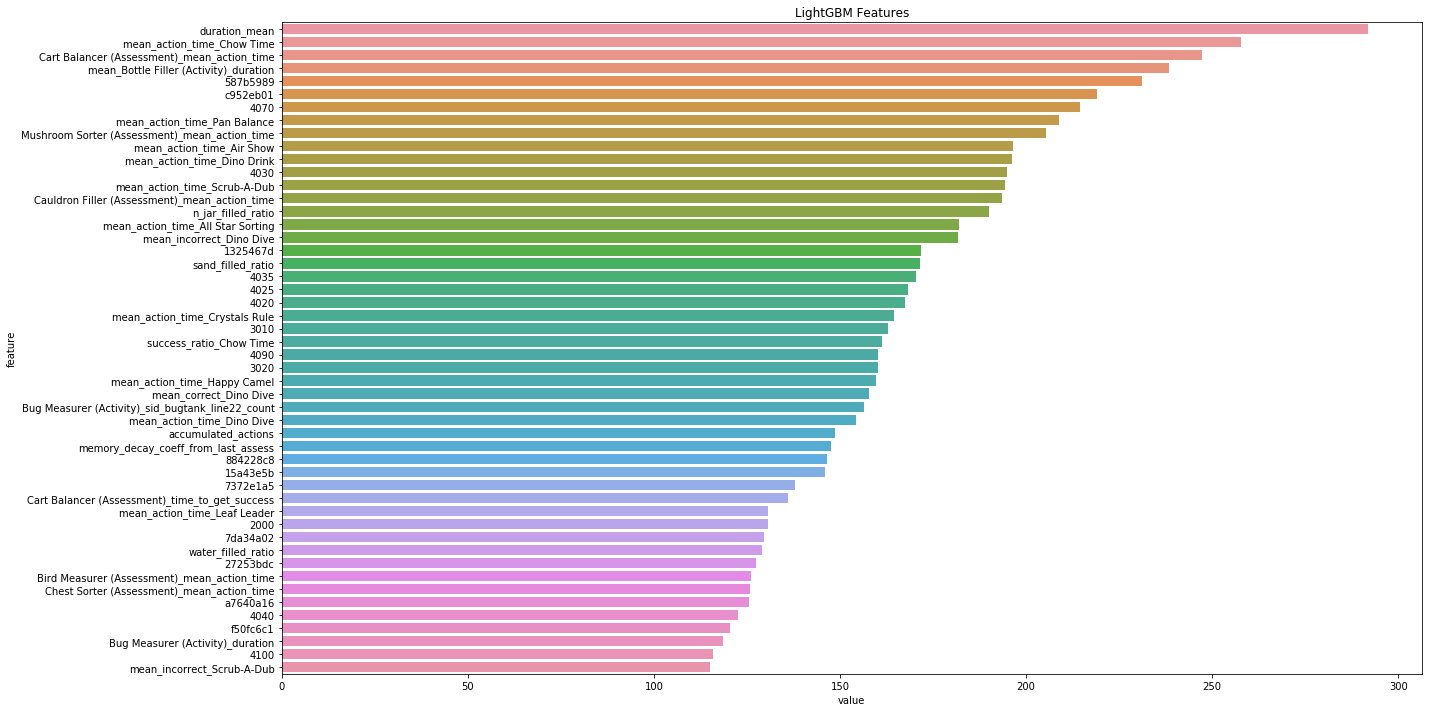

In [36]:
logging.info("Adversarial Validation")
train_adv = x_train.copy()
test_adv = x_valid.copy()

train_adv["target"] = 0
test_adv["target"] = 1
groups_adv = np.concatenate([groups, groups_valid])
train_test_adv = pd.concat([train_adv, test_adv], axis=0,
                           sort=False).reset_index(drop=True)

train_test_adv["group"] = groups_adv
splits = get_validation(train_test_adv, merged_config)
train_test_adv.drop("group", axis=1, inplace=True)

aucs = []
importance = np.zeros(len(cols))
for fold, (trn_idx, val_idx) in enumerate(splits):
    print("=" * 20)
    print(f"Fold: {fold}")
    print("=" * 20)

    x_train_adv = train_test_adv.loc[trn_idx, cols]
    y_train_adv = train_test_adv.loc[trn_idx, "target"]
    x_val_adv = train_test_adv.loc[val_idx, cols]
    y_val_adv = train_test_adv.loc[val_idx, "target"]

    train_lgb = lgb.Dataset(x_train_adv, label=y_train_adv)
    valid_lgb = lgb.Dataset(x_val_adv, label=y_val_adv)

    model_params = merged_config["av"]["model_params"]
    train_params = merged_config["av"]["train_params"]
    clf = lgb.train(
        model_params,
        train_lgb,
        valid_sets=[train_lgb, valid_lgb],
        valid_names=["train", "valid"],
        **train_params)

    aucs.append(clf.best_score)
    importance += clf.feature_importance(
        importance_type="gain") / len(splits)

# Check the feature importance
feature_imp = pd.DataFrame(
    sorted(zip(importance, cols)), columns=["value", "feature"])

plt.figure(figsize=(20, 10))
sns.barplot(
    x="value",
    y="feature",
    data=feature_imp.sort_values(by="value", ascending=False).head(50))
plt.title("LightGBM Features")
plt.tight_layout()
plt.savefig(output_dir / "feature_importance_adv.png")

merged_config["av_result"] = dict()
merged_config["av_result"]["score"] = dict()
for i, auc in enumerate(aucs):
    merged_config["av_result"]["score"][f"fold{i}"] = auc

merged_config["av_result"]["feature_importances"] = \
    feature_imp.set_index("feature").sort_values(
        by="value",
        ascending=False
    ).to_dict()["value"]

### Train model

#### CatBoost model 

+++++++++++++++++++++++++
seed: 123
+++++++++++++++++++++++++
Assessment Class: 4
Fold: 1
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 212ms	remaining: 21m 11s
100:	learn: 0.3662707	test: 0.3342611	best: 0.3342611 (100)	total: 13.7s	remaining: 13m 17s
200:	learn: 0.4495231	test: 0.3927675	best: 0.4188781 (195)	total: 27.3s	remaining: 13m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4188780566
bestIteration = 195

Shrink model to first 196 iterations.
Fold: 2
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 134ms	remaining: 13m 25s
100:	learn: 0.3728144	test: 0.2847471	best: 0.2847471 (100)	total: 13.2s	remaining: 12m 51s
200:	learn: 0.4453332	test: 0.3192595	best: 0.3275693 (146)	total: 26s	remaining: 12m 31s
300:	learn: 0.4843140	test: 0.3326486	best: 0.3329935 (228)	total: 38.7s	remaining: 12m 12s
400:	learn: 0.5208331	test: 0.3422468	best: 0.3422468 (400)	total: 51.4s	remaining: 11m 57s
500:	learn: 0.5508441	test: 0.3344969	

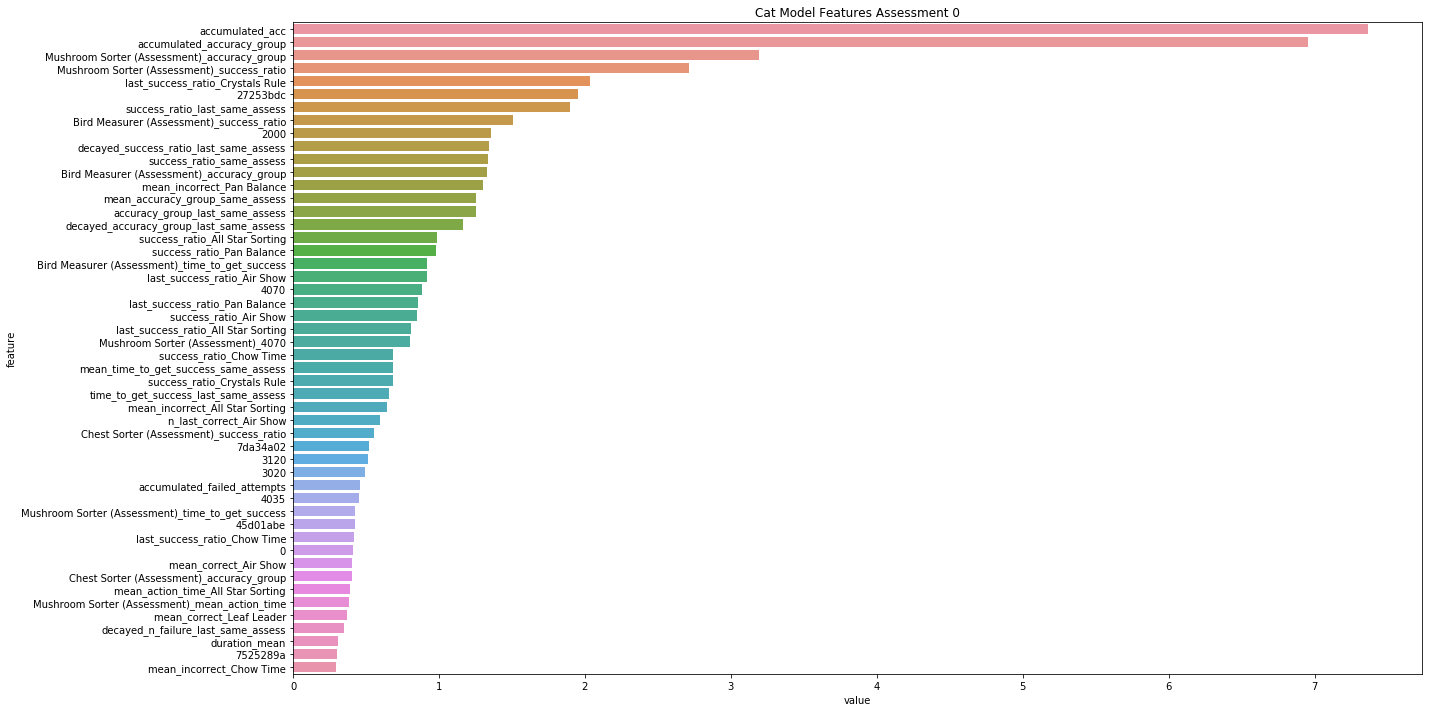

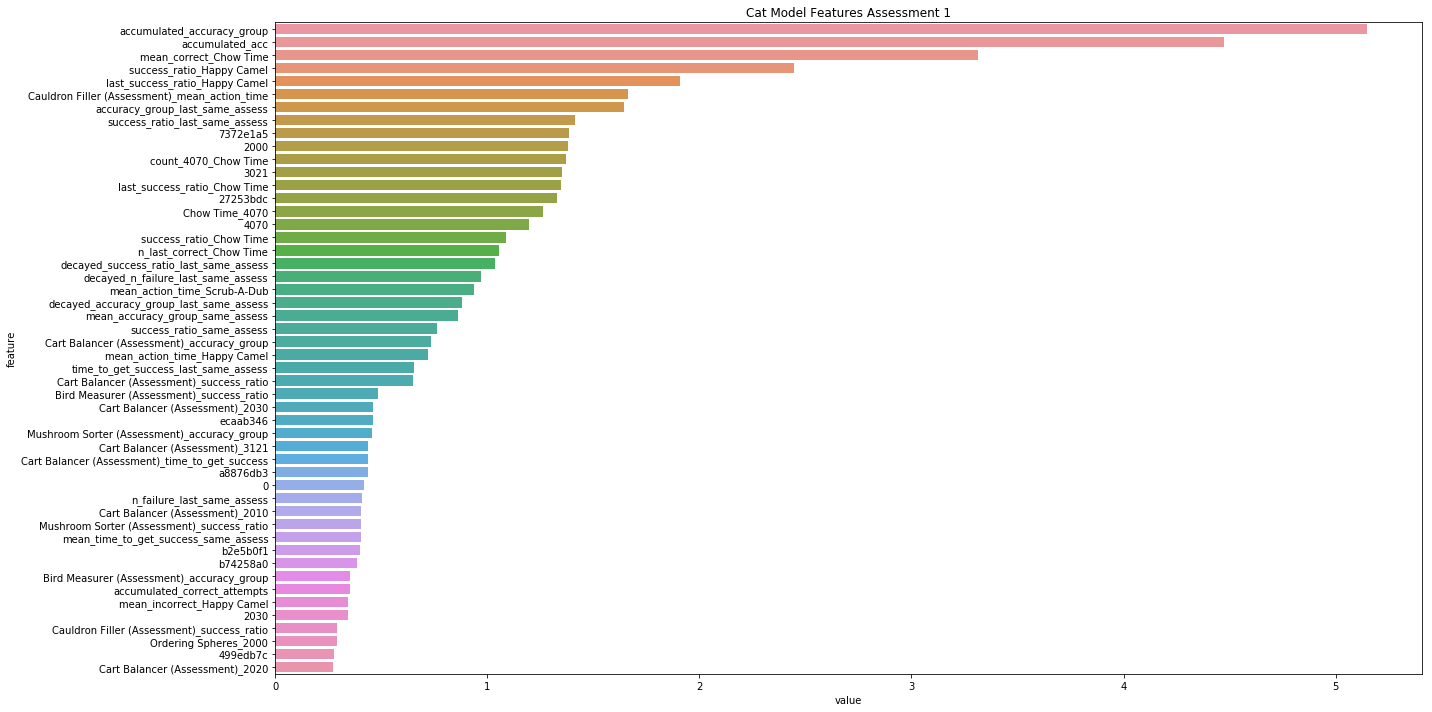

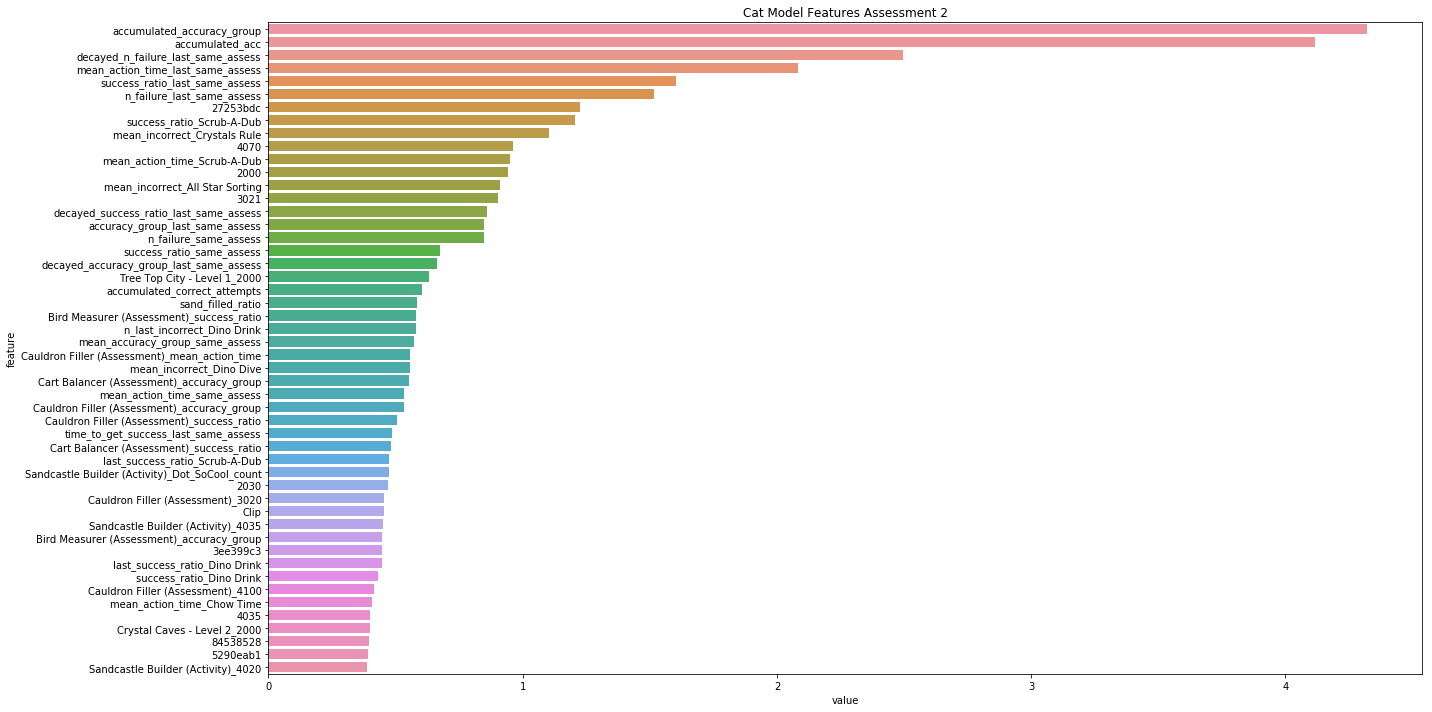

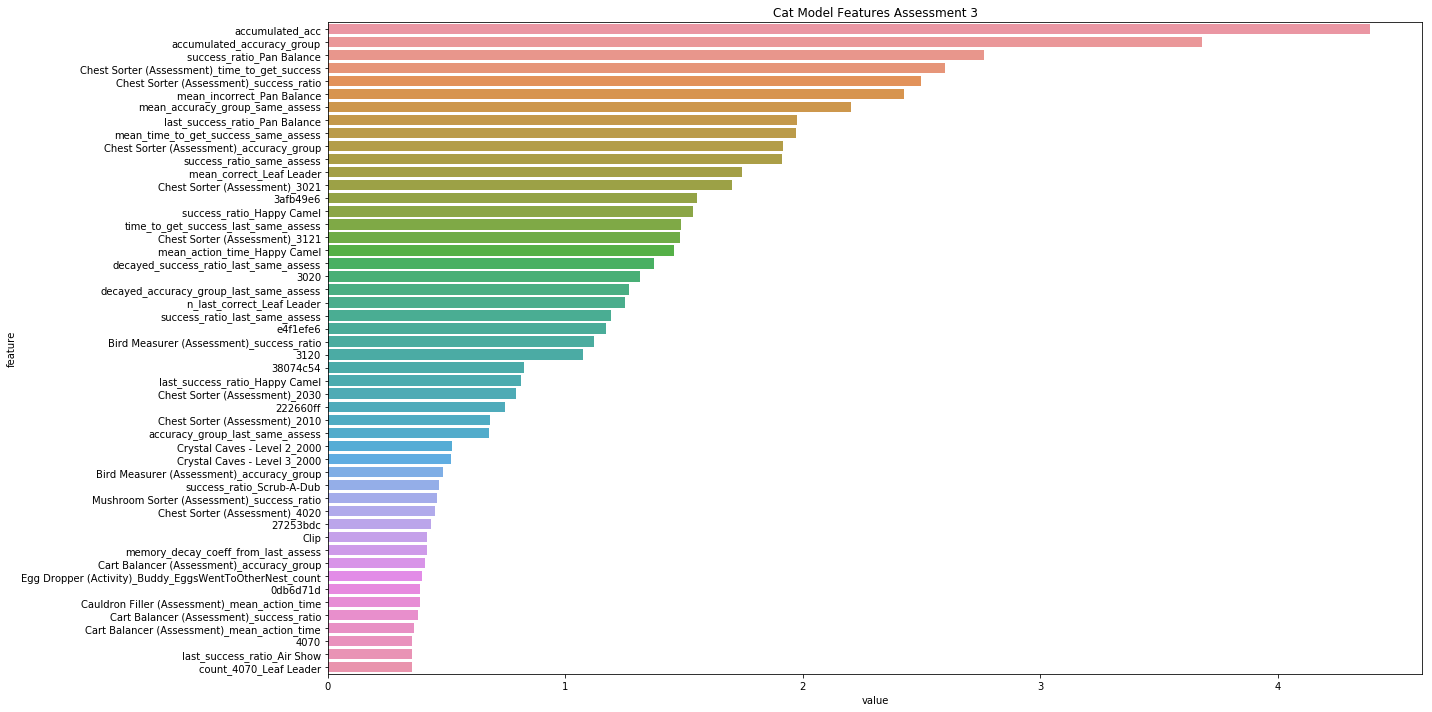

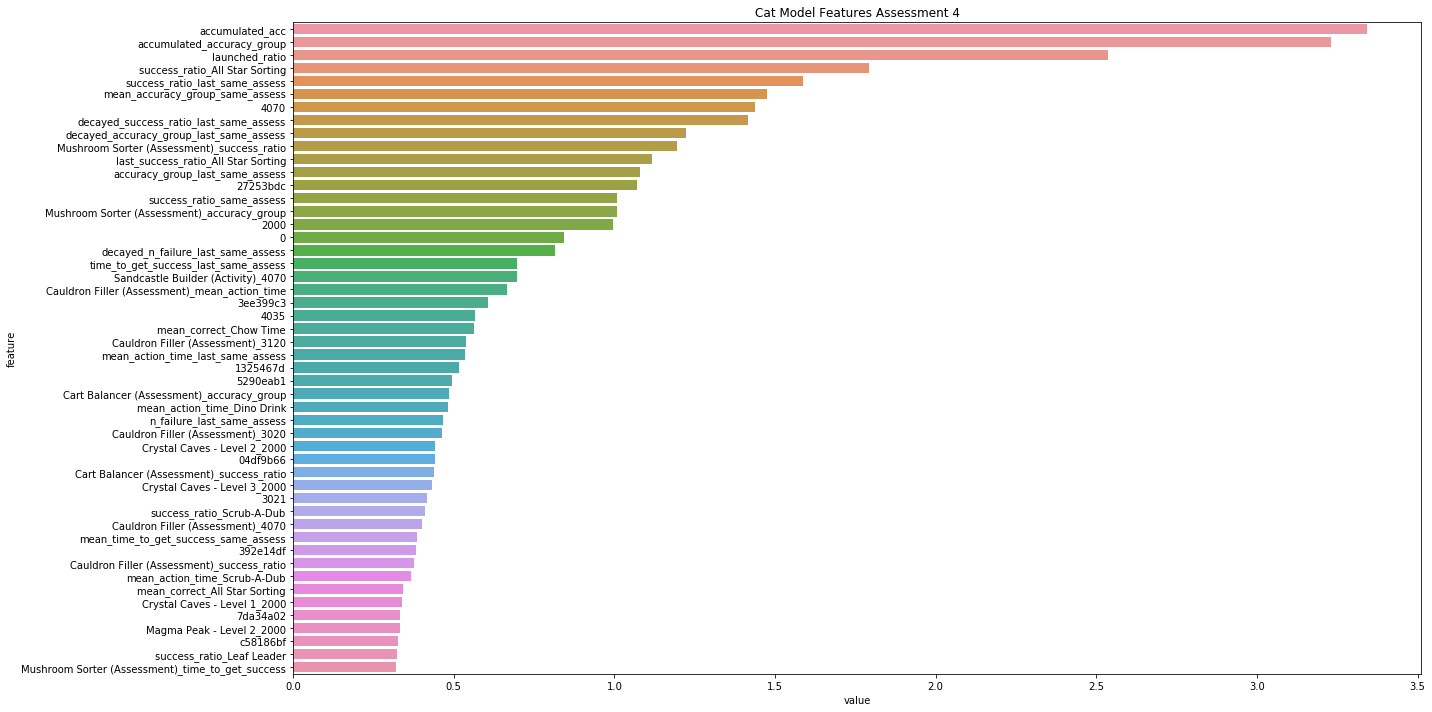

In [37]:
logging.info("Train model")
logging.info("CatBoost model")

model = get_model(cat_config)

avg_oof_preds = np.zeros(len(x_train))
avg_test_preds = np.zeros(len(x_test))
avg_valid_preds = np.zeros(len(x_valid))

importances = {
    i: pd.DataFrame(index=cols) for i in range(5)
}

seed_sets = [123, 456, 789, 101, 215]

for seed in seed_sets:
    print("+" * 25)
    print(f"seed: {seed}")
    print("+" * 25)
    
    cat_config["model"]["model_params"]["random_seed"] = seed
    
    cat_config["val"]["params"]["random_state"] = seed
    
    if "mean_target" in cols:
        cols.remove("mean_target")
    
    _, _, _, _, feature_importance, eval_results = model.cv(
        y_train,
        x_train[cols],
        x_test[cols],
        y_valid,
        x_valid[cols],
        feature_name=cols,
        groups=groups_adv,
        config=cat_config,
        log=True)
    avg_oof_preds += model.raw_oof_preds / (len(seed_sets) * 2)
    avg_test_preds += model.raw_test_preds / (len(seed_sets) * 2)
    avg_valid_preds += model.raw_valid_preds / (len(seed_sets) * 2)
    
    merged_config[f"eval_results_seed{seed}"] = dict()
    for k, v in eval_results.items():
        merged_config[f"eval_results_seed{seed}"][k] = v
        
    for i in range(5):
        importances[i] = importances[i].join(
            feature_importance[i].to_frame().rename(
                columns={0: f"seed{seed}"}), how="inner")
    
    

for i in range(5):    
    feature_imp = importances[i].mean(axis=1).reset_index().rename(
        columns={
            "index": "feature",
            0: "value"
        })

    plt.figure(figsize=(20, 10))
    sns.barplot(
        x="value",
        y="feature",
        data=feature_imp.sort_values(by="value", ascending=False).head(50))
    plt.title(f"Cat Model Features Assessment {i}")
    plt.tight_layout()
    plt.savefig(output_dir / f"feature_importance_Cat_Assessment{i}.png")

#### LGBM model

+++++++++++++++++++++++++
seed: 387
+++++++++++++++++++++++++
Assessment Class: 4
Fold: 1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's qwk: 0.318351
[200]	valid_0's qwk: 0.325143
Early stopping, best iteration is:
[108]	valid_0's qwk: 0.333223
Fold: 2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's qwk: 0.375582
[200]	valid_0's qwk: 0.40165
[300]	valid_0's qwk: 0.433676
Early stopping, best iteration is:
[290]	valid_0's qwk: 0.436298
Fold: 3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's qwk: 0.336781
[200]	valid_0's qwk: 0.351756
Early stopping, best iteration is:
[144]	valid_0's qwk: 0.367092
Fold: 4
Training until validation scores don't improve for 100 rounds
[100]	valid_0's qwk: 0.337697
[200]	valid_0's qwk: 0.364689
[300]	valid_0's qwk: 0.37453
[400]	valid_0's qwk: 0.386668
[500]	valid_0's qwk: 0.399353
Early stopping, best iteration is:
[411]	valid_0's qwk: 0.410425
Fold: 5
Training unt

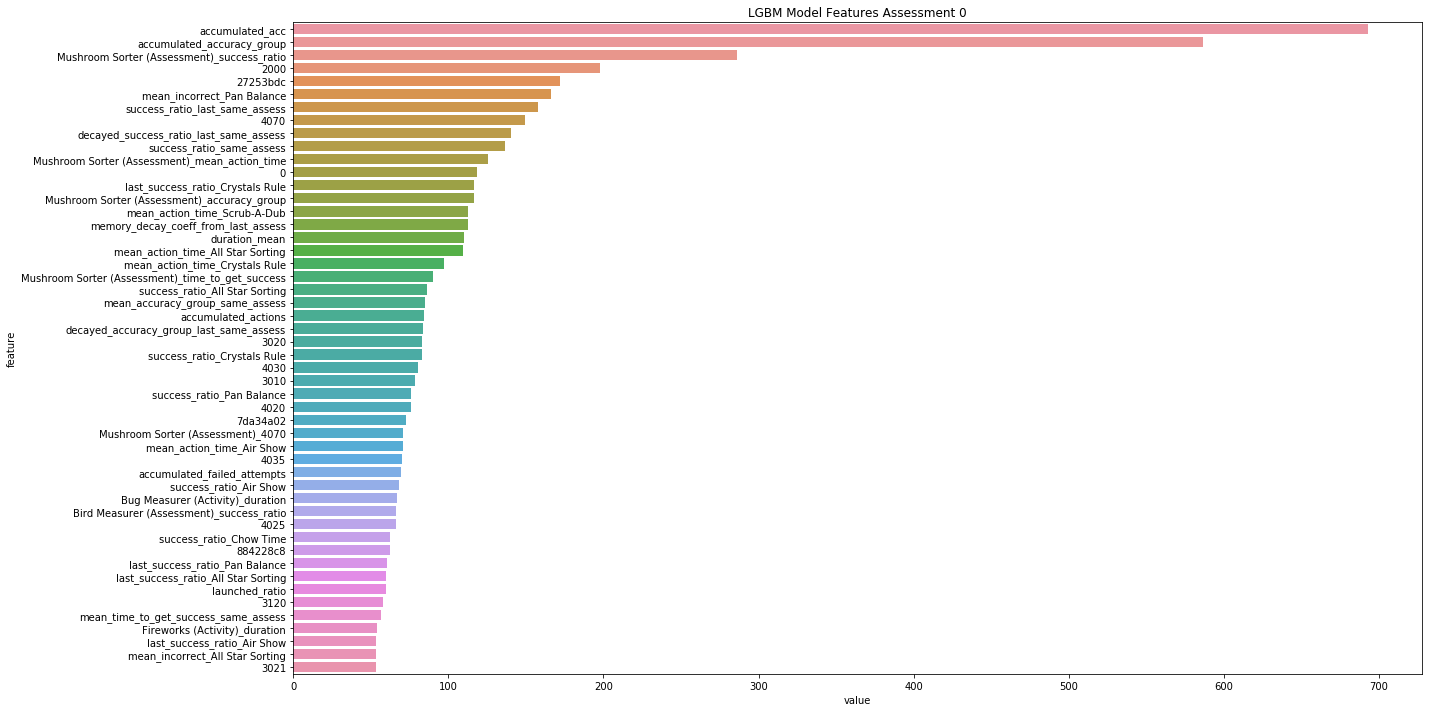

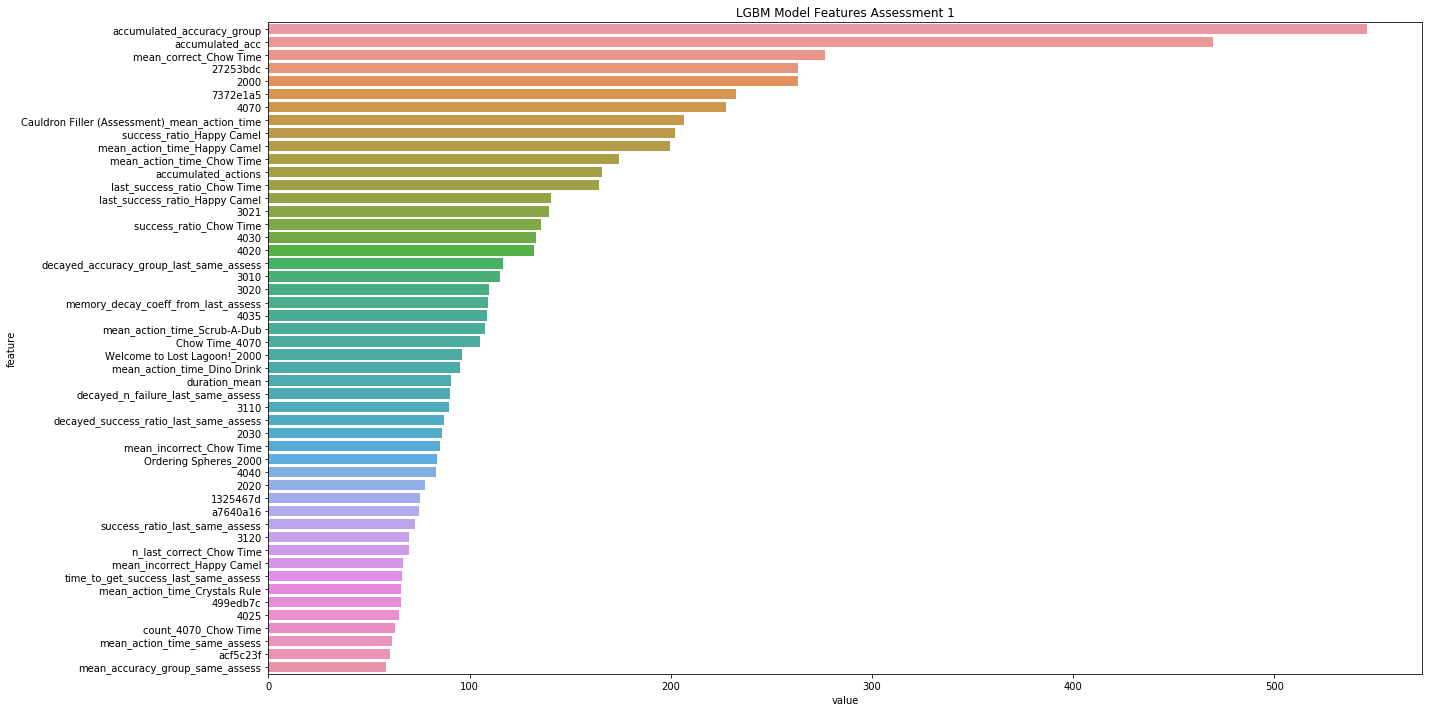

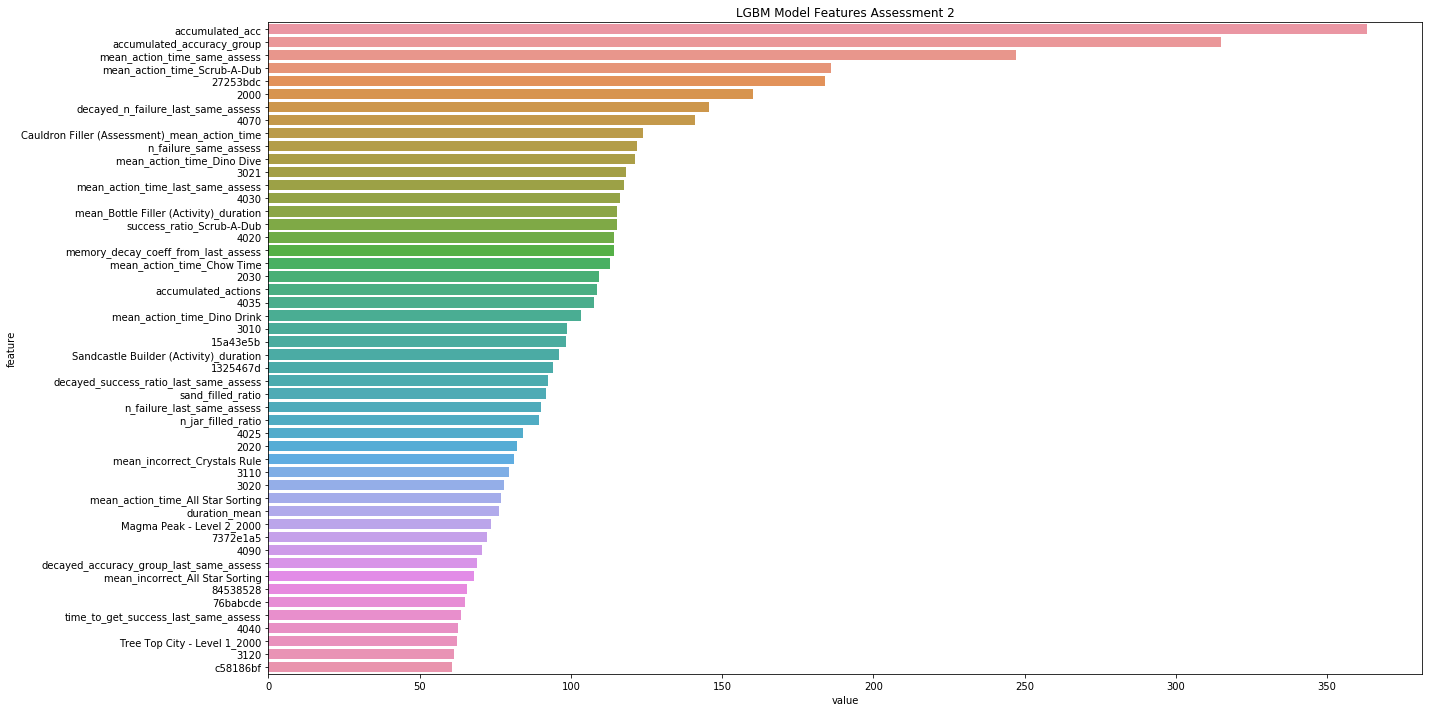

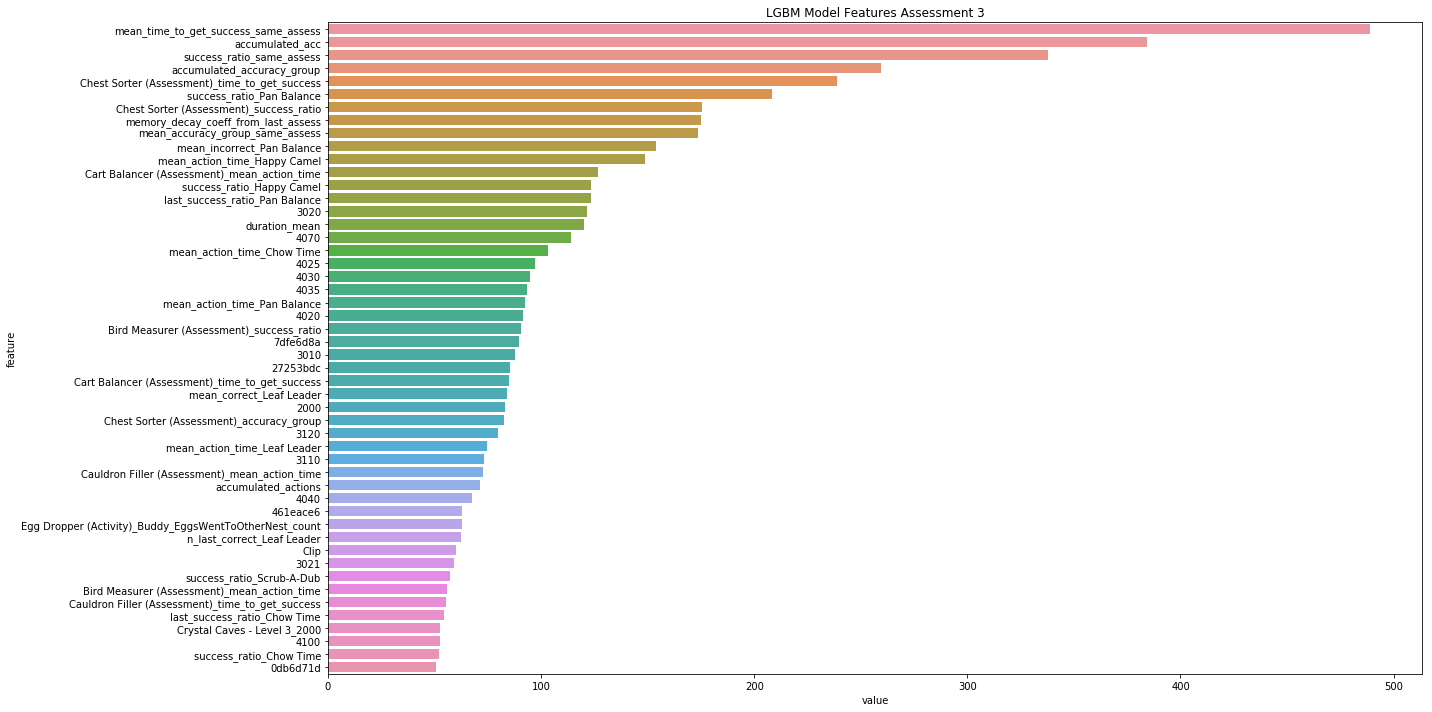

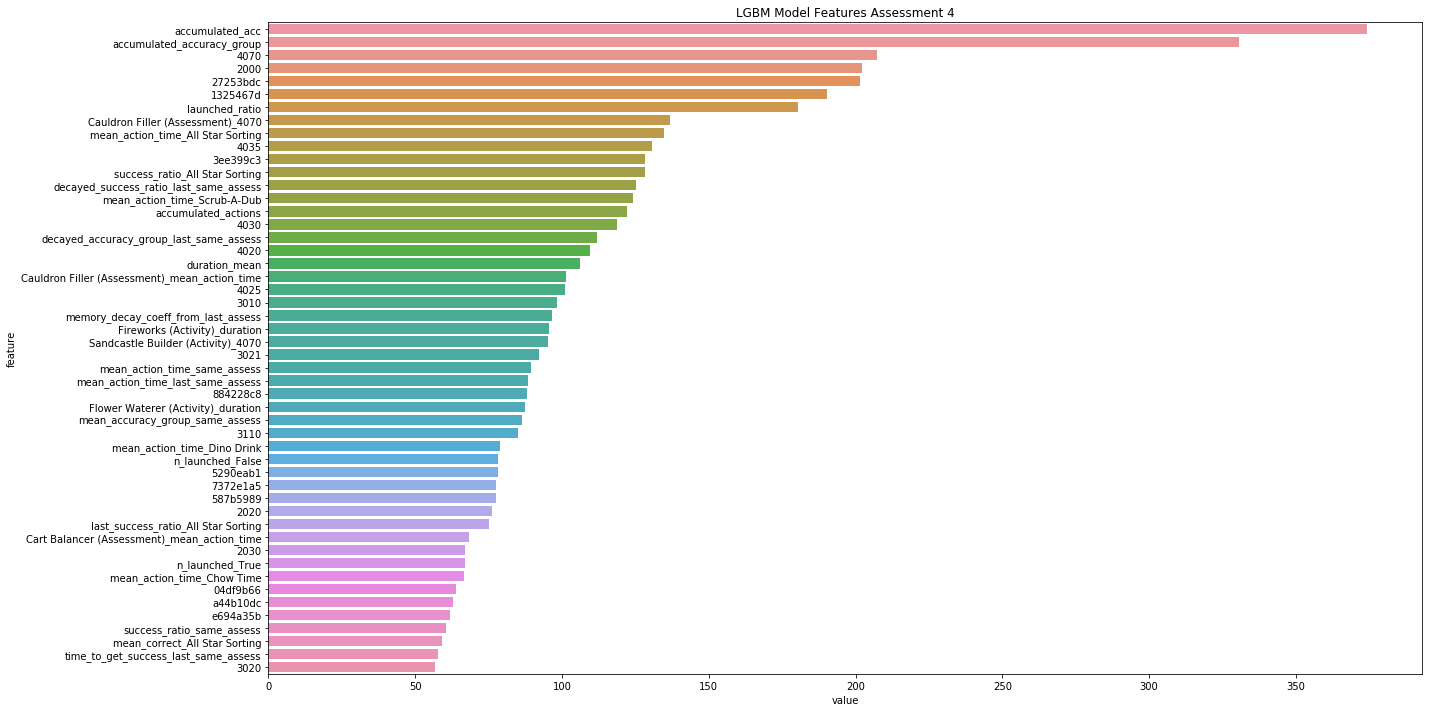

In [38]:
logging.info("Train model")

model = get_model(lgb_config)

importances = {
    i: pd.DataFrame(index=cols) for i in range(5)
}

seed_sets = [387, 289, 908, 634, 445]
for seed in seed_sets:
    print("+" * 25)
    print(f"seed: {seed}")
    print("+" * 25)
    
    lgb_config["model"]["model_params"]["seed"] = seed
    lgb_config["model"]["model_params"]["drop_seed"] = seed
    lgb_config["model"]["model_params"]["bagging_seed"] = seed
    lgb_config["model"]["model_params"]["feature_fraction_seed"] = seed
    
    lgb_config["val"]["params"]["random_state"] = seed
    
    # get folds
    x_train["group"] = groups
    splits = get_validation(x_train, lgb_config)
    x_train.drop("group", axis=1, inplace=True)
    
    if "mean_target" in cols:
        cols.remove("mean_target")
    
    _, _, _, _, feature_importance, eval_results = model.cv(
        y_train,
        x_train[cols],
        x_test[cols],
        y_valid,
        x_valid[cols],
        feature_name=cols,
        groups=groups_adv,
        config=lgb_config,
        log=True)
    avg_oof_preds += model.raw_oof_preds / (len(seed_sets) * 2)
    avg_test_preds += model.raw_test_preds / (len(seed_sets) * 2)
    avg_valid_preds += model.raw_valid_preds / (len(seed_sets) * 2)
    
    merged_config[f"eval_results_seed{seed}"] = dict()
    for k, v in eval_results.items():
        merged_config[f"eval_results_seed{seed}"][k] = v
        
    for i in range(5):
        importances[i] = importances[i].join(
            feature_importance[i].to_frame().rename(
                columns={0: f"seed{seed}"}), how="inner")
    
for i in range(5):    
    feature_imp = importances[i].mean(axis=1).reset_index().rename(
        columns={
            "index": "feature",
            0: "value"
        })

    plt.figure(figsize=(20, 10))
    sns.barplot(
        x="value",
        y="feature",
        data=feature_imp.sort_values(by="value", ascending=False).head(50))
    plt.title(f"LGBM Model Features Assessment {i}")
    plt.tight_layout()
    plt.savefig(output_dir / f"feature_importance_LGBM_Assessment{i}.png")

### cat2

+++++++++++++++++++++++++
seed: 637
+++++++++++++++++++++++++
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 255ms	remaining: 25m 29s
100:	learn: 0.5078357	test: 0.5422153	best: 0.5422153 (100)	total: 27s	remaining: 26m 15s
200:	learn: 0.5755166	test: 0.5928940	best: 0.5928940 (200)	total: 53.9s	remaining: 25m 55s
300:	learn: 0.5904488	test: 0.6042832	best: 0.6045244 (298)	total: 1m 20s	remaining: 25m 24s
400:	learn: 0.6047299	test: 0.6059291	best: 0.6078087 (380)	total: 1m 46s	remaining: 24m 53s
500:	learn: 0.6143417	test: 0.6110108	best: 0.6110108 (500)	total: 2m 13s	remaining: 24m 24s
600:	learn: 0.6213974	test: 0.6122270	best: 0.6125650 (582)	total: 2m 39s	remaining: 23m 56s
700:	learn: 0.6275169	test: 0.6142262	best: 0.6149475 (674)	total: 3m 6s	remaining: 23m 28s
800:	learn: 0.6310336	test: 0.6140085	best: 0.6158449 (777)	total: 3m 32s	remaining: 23m
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6158448923
bestIteration = 777

Shrink model t

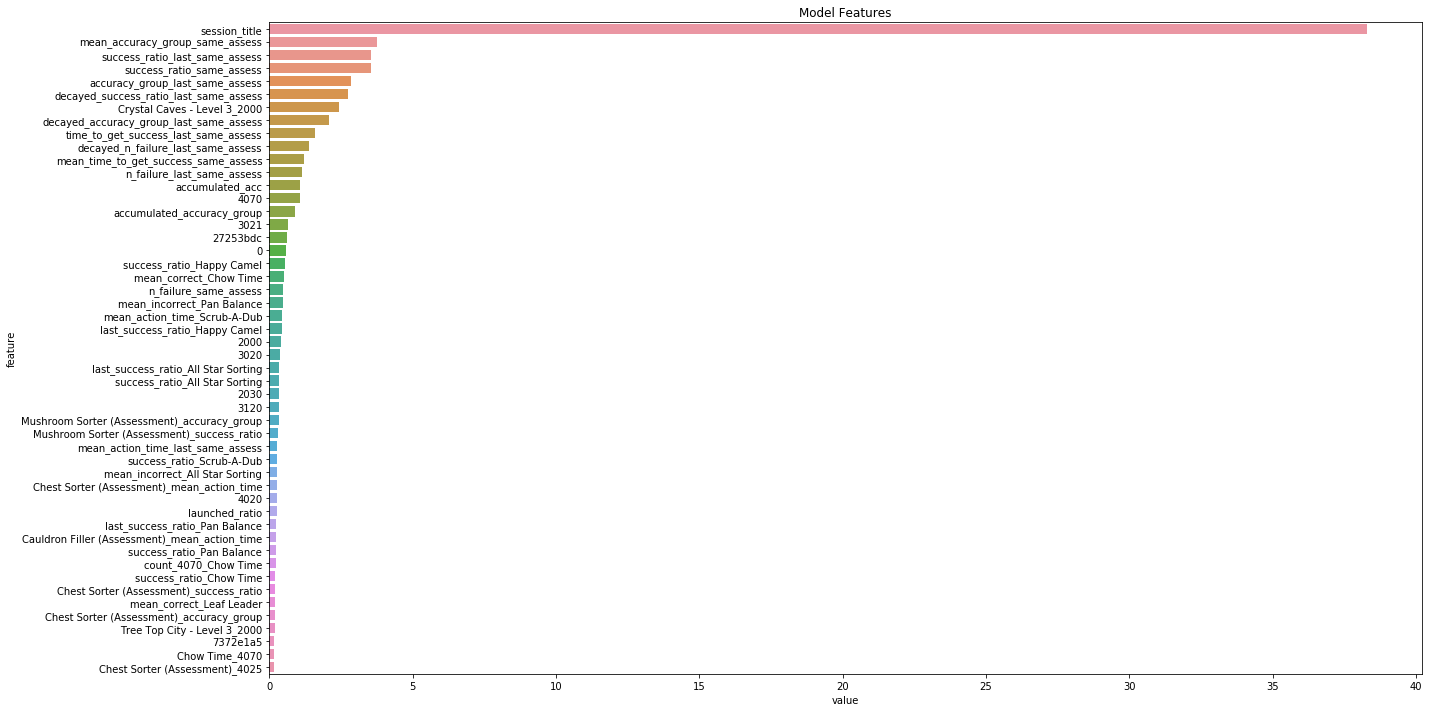

In [63]:
logging.info("Train model")
logging.info("CatBoost model")

model = get_model(cat_config2)

avg_oof_preds2 = np.zeros(len(x_train))
avg_test_preds2 = np.zeros(len(x_test))
avg_valid_preds2 = np.zeros(len(x_valid))

importances = pd.DataFrame(index=cols)

seed_sets = [637, 229, 890, 1234, 7682]

for seed in seed_sets:
    print("+" * 25)
    print(f"seed: {seed}")
    print("+" * 25)
    
    cat_config2["model"]["model_params"]["random_seed"] = seed
    
    cat_config2["val"]["params"]["random_state"] = seed
    
    # get folds
    x_train["group"] = groups
    splits = get_validation(x_train, cat_config2)
    x_train.drop("group", axis=1, inplace=True)
    
    # if "mean_target" not in cols:
    #     cols.append("mean_target")
    
    _, _, _, _, feature_importance, eval_results = model.cv(
        y_train,
        x_train[cols],
        x_test[cols],
        y_valid,
        x_valid[cols],
        feature_name=cols,
        groups=groups_adv,
        config=cat_config2,
        log=True)
    avg_oof_preds2 += model.raw_oof_preds / (len(seed_sets) * 2)
    avg_test_preds2 += model.raw_test_preds / (len(seed_sets) * 2)
    avg_valid_preds2 += model.raw_valid_preds / (len(seed_sets) * 2)
    
    merged_config[f"eval_results_seed{seed}"] = dict()
    for k, v in eval_results.items():
        merged_config[f"eval_results_seed{seed}"][k] = v
        
    feature_importance = feature_importance.to_frame().rename(
        columns={0: f"seed{seed}"})
    importances = importances.join(feature_importance, how="inner")
    
feature_imp = importances.mean(axis=1).reset_index().rename(
    columns={
        "index": "feature",
        0: "value"
    })

plt.figure(figsize=(20, 10))
sns.barplot(
    x="value",
    y="feature",
    data=feature_imp.sort_values(by="value", ascending=False).head(50))
plt.title("Model Features")
plt.tight_layout()
plt.savefig(output_dir / "feature_importance_Cat2.png")

### lgb

+++++++++++++++++++++++++
seed: 734
+++++++++++++++++++++++++
Training until validation scores don't improve for 100 rounds
[100]	valid's qwk: 0.473658
[200]	valid's qwk: 0.563316
[300]	valid's qwk: 0.581398
[400]	valid's qwk: 0.586561
[500]	valid's qwk: 0.582548
Early stopping, best iteration is:
[402]	valid's qwk: 0.587217
Training until validation scores don't improve for 100 rounds
[100]	valid's qwk: 0.488085
[200]	valid's qwk: 0.572347
[300]	valid's qwk: 0.585891
[400]	valid's qwk: 0.591685
[500]	valid's qwk: 0.591733
Early stopping, best iteration is:
[430]	valid's qwk: 0.595484
Training until validation scores don't improve for 100 rounds
[100]	valid's qwk: 0.501819
[200]	valid's qwk: 0.587857
[300]	valid's qwk: 0.598922
[400]	valid's qwk: 0.600635
Early stopping, best iteration is:
[334]	valid's qwk: 0.601392
Training until validation scores don't improve for 100 rounds
[100]	valid's qwk: 0.502063
[200]	valid's qwk: 0.578678
[300]	valid's qwk: 0.592486
[400]	valid's qwk: 0.5965

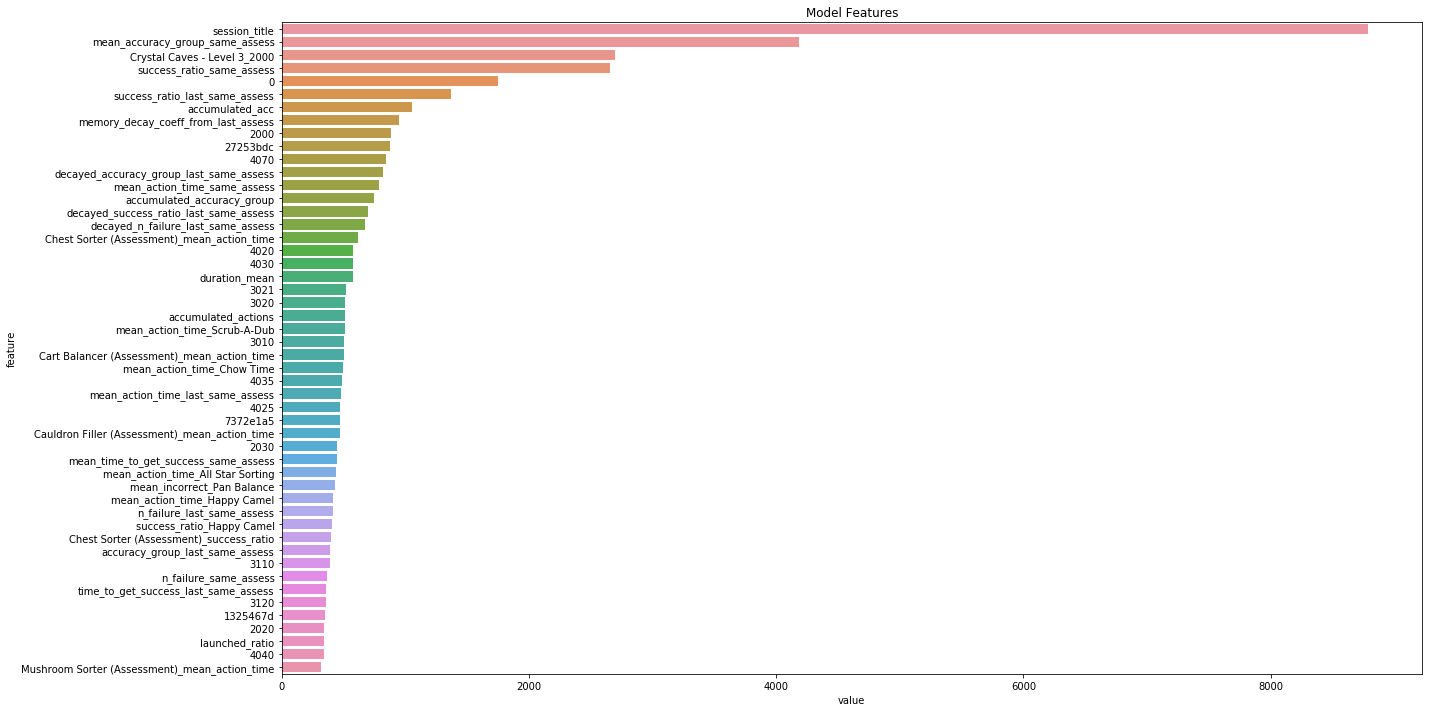

In [64]:
logging.info("Train model")

model = get_model(lgb_config2)

importances = pd.DataFrame(index=cols)

seed_sets = [734, 23245, 112, 768, 9970]
for seed in seed_sets:
    print("+" * 25)
    print(f"seed: {seed}")
    print("+" * 25)
    
    lgb_config2["model"]["model_params"]["seed"] = seed
    lgb_config2["model"]["model_params"]["drop_seed"] = seed
    lgb_config2["model"]["model_params"]["bagging_seed"] = seed
    lgb_config2["model"]["model_params"]["feature_fraction_seed"] = seed
    
    lgb_config2["val"]["params"]["random_state"] = seed
    
    # if "mean_target" not in cols:
    #     cols.append("mean_target")
    
    _, _, _, _, feature_importance, eval_results = model.cv(
        y_train,
        x_train[cols],
        x_test[cols],
        y_valid,
        x_valid[cols],
        feature_name=cols,
        groups=groups_adv,
        config=lgb_config2,
        log=True)
    avg_oof_preds2 += model.raw_oof_preds / (len(seed_sets) * 2)
    avg_test_preds2 += model.raw_test_preds / (len(seed_sets) * 2)
    avg_valid_preds2 += model.raw_valid_preds / (len(seed_sets) * 2)
    
    merged_config[f"eval_results_seed{seed}"] = dict()
    for k, v in eval_results.items():
        merged_config[f"eval_results_seed{seed}"][k] = v
        
    feature_importance = feature_importance.to_frame().rename(
        columns={0: f"seed{seed}"})
    importances = importances.join(feature_importance, how="inner")
    
feature_imp = importances.mean(axis=1).reset_index().rename(
    columns={
        "index": "feature",
        0: "value"
    })

plt.figure(figsize=(20, 10))
sns.barplot(
    x="value",
    y="feature",
    data=feature_imp.sort_values(by="value", ascending=False).head(50))
plt.title("Model Features")
plt.tight_layout()
plt.savefig(output_dir / "feature_importance_LGB2.png")

### Save

In [65]:
save_path = output_dir / "output.json"
save_json(merged_config, save_path)

### Ensemble

In [66]:
avg_oof_preds_ = (avg_oof_preds + avg_oof_preds2) / 2
avg_test_preds_ = (avg_test_preds + avg_test_preds2) / 2
avg_valid_preds_ = (avg_valid_preds + avg_valid_preds2) / 2

In [67]:
OptR = OptimizedRounder(n_classwise=20, n_overall=20)
OptR.fit(avg_oof_preds_, y_train)

oof_preds_optimized = OptR.predict(avg_oof_preds_)
test_preds_optimized = OptR.predict(avg_test_preds_)
valid_preds_optimized = OptR.predict(avg_valid_preds_)

oof_score = calc_metric(oof_preds_optimized, y_train)
print(f"Optimized OOF QWK: {oof_score:.4f}")
valid_score = calc_metric(valid_preds_optimized, y_valid)
print(f"Optimized valid QWK: {valid_score:.4f}")

Optimized OOF QWK: 0.6112
Optimized valid QWK: 0.5883


In [68]:
OptR2 = OptimizedRounder(n_classwise=20, n_overall=20)
OptR2.fit(avg_valid_preds_, y_valid)

oof_preds_optimized2 = OptR2.predict(avg_oof_preds_)
test_preds_optimized2 = OptR2.predict(avg_test_preds_)
valid_preds_optimized2 = OptR2.predict(avg_valid_preds_)

oof_score2 = calc_metric(oof_preds_optimized2, y_train)
print(f"Optimized OOF QWK2: {oof_score2:.4f}")
valid_score2 = calc_metric(valid_preds_optimized2, y_valid)
print(f"Optimized valid QWK2: {valid_score2:.4f}")

Optimized OOF QWK2: 0.6092
Optimized valid QWK2: 0.5927


Normalized confusion matrix
[[0.51879877 0.21328919 0.18113029 0.08678175]
 [0.17378681 0.27001244 0.32019909 0.23600166]
 [0.06575964 0.14331066 0.34195011 0.44897959]
 [0.02577728 0.07043527 0.25890334 0.64488412]]
Normalized confusion matrix
[[0.49761905 0.21666667 0.19761905 0.08809524]
 [0.15471698 0.2490566  0.32075472 0.2754717 ]
 [0.06198347 0.1322314  0.28512397 0.52066116]
 [0.02749771 0.06049496 0.27406049 0.63794684]]


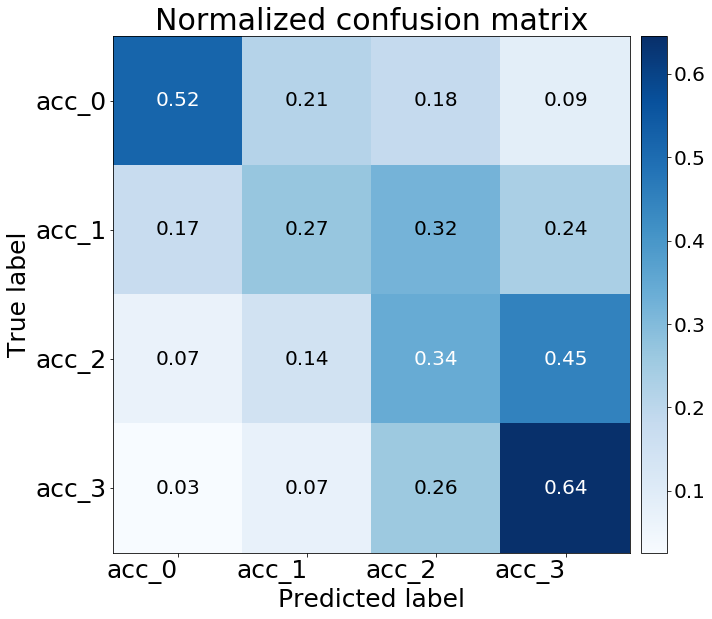

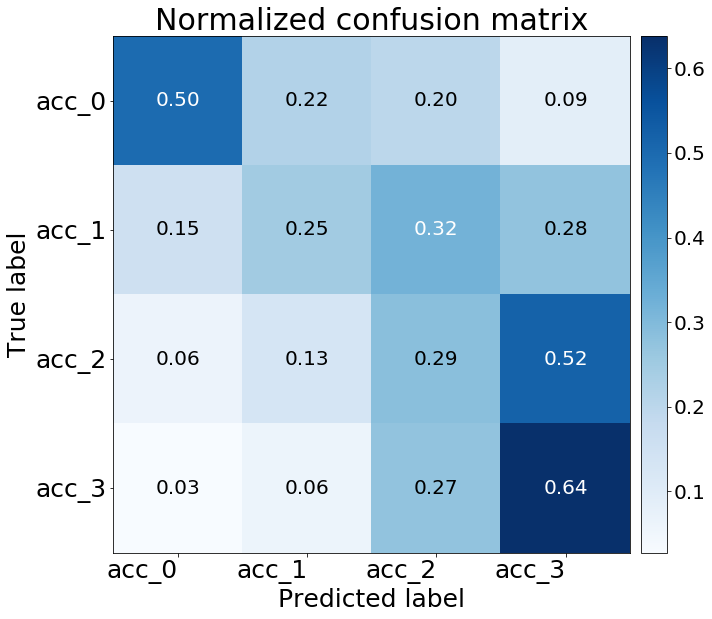

In [69]:
# Confusion Matrix
plot_confusion_matrix(
    y_train,
    oof_preds_optimized,
    classes=np.array(["acc_0", "acc_1", "acc_2", "acc_3"]),
    normalize=True,
    save_path=output_dir / "confusion_matrix_oof.png")
plot_confusion_matrix(
    y_valid,
    valid_preds_optimized,
    classes=np.array(["acc_0", "acc_1", "acc_2", "acc_3"]),
    normalize=True,
    save_path=output_dir / "confusion_matrix_valid.png")

Normalized confusion matrix
[[0.57058406 0.15795696 0.18727832 0.08418066]
 [0.22729158 0.21318955 0.3284944  0.23102447]
 [0.08798186 0.11746032 0.35011338 0.44444444]
 [0.03787451 0.05743358 0.26794799 0.63674392]]
Normalized confusion matrix
[[0.57142857 0.14285714 0.2        0.08571429]
 [0.19245283 0.21132075 0.32830189 0.26792453]
 [0.0785124  0.11570248 0.28512397 0.52066116]
 [0.03849679 0.04949588 0.27681027 0.63519707]]


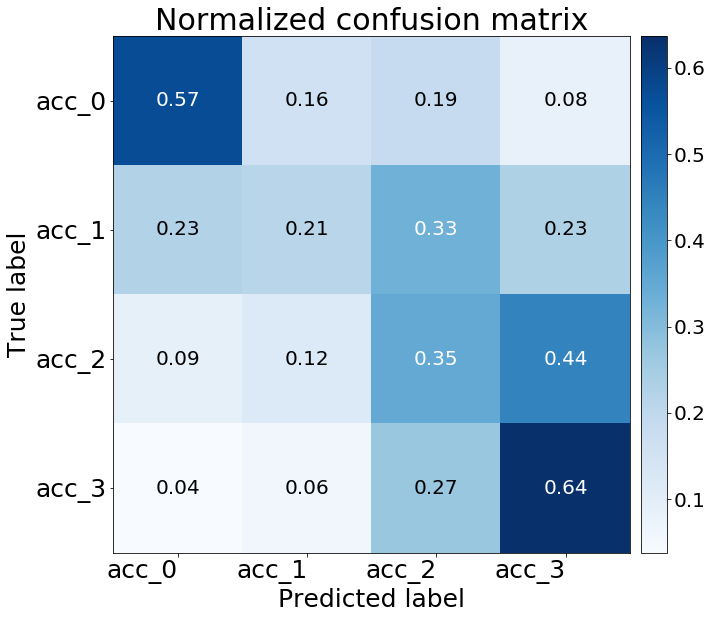

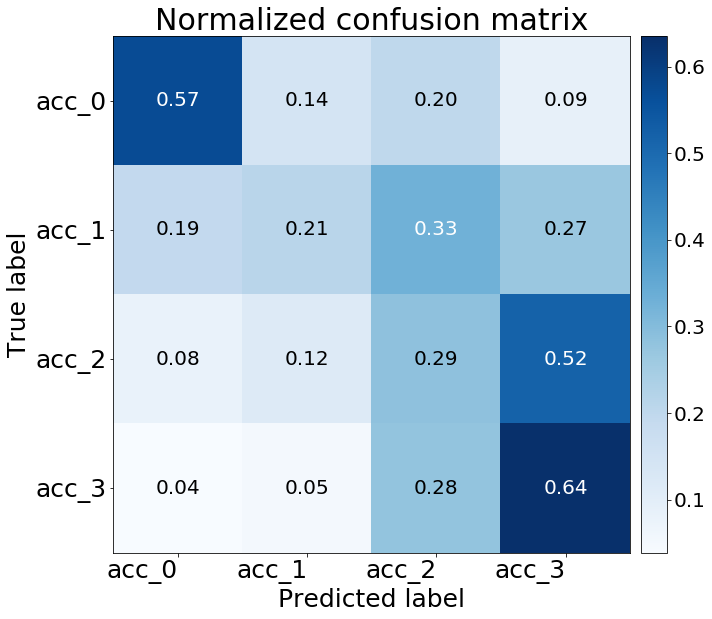

In [70]:
# Confusion Matrix
plot_confusion_matrix(
    y_train,
    oof_preds_optimized2,
    classes=np.array(["acc_0", "acc_1", "acc_2", "acc_3"]),
    normalize=True,
    save_path=output_dir / "confusion_matrix_oof2.png")
plot_confusion_matrix(
    y_valid,
    valid_preds_optimized2,
    classes=np.array(["acc_0", "acc_1", "acc_2", "acc_3"]),
    normalize=True,
    save_path=output_dir / "confusion_matrix_valid2.png")

### Make submission

In [41]:
sample_submission = pd.read_csv(
    input_dir / "sample_submission.csv")
sample_submission["accuracy_group"] = test_preds_optimized2
sample_submission.to_csv('submission.csv', index=None)
sample_submission.head()

,installation_id,accuracy_group
0,00abaee7,2
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3
